In [1]:
import numpy as np, xarray as xr, pandas as pd, matplotlib.pyplot as plt,seaborn as sns
import cartopy.feature as cfeature, cartopy.crs as ccrs
import matplotlib.colors as colors, matplotlib.cm as cm, matplotlib.colorbar as colorbar, matplotlib.patches as mpatches, matplotlib.lines as mlines, matplotlib.cbook as cbook
import re, sys, ngl, os, Nio, copy
from netCDF4 import Dataset
from datetime import datetime,timedelta
from glob import glob
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

sys.path.insert(0, '/global/u2/w/wandiyu/functions/')
%run /global/u2/w/wandiyu/functions/load_functions.py
import warnings
warnings.filterwarnings("ignore")
plt.style.context('seaborn-notebook')

In [2]:
data_colors = {'MMF_default': 'forestgreen'
          , 'E3SM_default':'darkorange'
          ,'MMF_refined':'forestgreen'
          , 'E3SM_refined':'darkorange'
        , 'E3SM_L128':'darkorange'
          , 'ERA5':'k'}
linestyles = {'MMF_default': '--'
          , 'E3SM_default':'--'
          ,'MMF_refined':'-'
          , 'E3SM_refined':'-'
        , 'E3SM_L128':'-.'
          , 'ERA5':'-'}
markers = {'MMF_default': 'x'
          , 'E3SM_default':'x'
          ,'MMF_refined':'o'
          , 'E3SM_refined':'o'
        , 'E3SM_L128':'2'
          , 'ERA5':'-'}

# funtions

In [3]:
def zonal_mean(ds,var_name, lat1= -90, lat2=90):
    '''
    calculate zonal mean value betwwen lat1 and lat 2
    input data: ds, xarray dataset, containing variable 'area', 'lat', and 'lon', or 'ncol'
    
    '''
    import xarray as xr, numpy as np 
    if lat1>lat2: lat1,lat2 = lat2,lat1
    if 'ncol' in ds.dims: 
        # original E3SM model output 
        lat = ds['lat']
        data = ds[var_name]
        area = ds['area']
        tmp_data = np.ones(lat.shape,dtype=bool)
        mask = xr.DataArray( tmp_data, coords=lat.coords, dims=lat.dims )
        mask = mask & ((lat>=lat1) & ((lat<=lat2)))

        data_avg = ( (data.where(mask)*area.where(mask)).sum(dim='ncol') / area.where(mask).sum(dim='ncol') )
    else:
        # gridded data 
        ds = ds.sel(lat=slice(lat1,lat2))
        data = ds[var_name]
        if 'area' in ds.data_vars:
            area = ds['area']
            data_avg = (data*area).sum(dim=('lon','lat')) / area.sum(dim=('lon','lat'))
        else:
            weight = np.cos(ds['lat']/180*np.pi)
            if 'lon' in ds.dims: 
                data_avg = (data*weight).sum(dim=('lon','lat')) / weight.sum(dim=('lon','lat'))
            else:
                data_avg = (data*weight).sum(dim=('lat')) / weight.sum(dim=('lat'))
    return data_avg

In [4]:
#-----------------------------
import scipy
def deseason(xraw):
    # Calculates the deseasonalized data
    months_per_year = 12
    # Create array to hold climatological values and deseasonalized data
    # Create months_per_year x 1 array of zeros
    xclim = np.zeros((months_per_year, 1))
    # Create array with same shape as xraw
    x_deseasoned = np.zeros(xraw.shape)
    # Iterate through all 12 months.
    for month in np.arange(months_per_year):
        # `xraw[month::12]` will return the data for this month every year (12 months)
        # (i.e., from month until the end of xraw, get every 12th month)
        # Get the mean of this month, using data from every year, ignoring NaNs
        xclim[month] = np.nanmean(xraw[month::months_per_year])
    num_years = int(np.floor(len(x_deseasoned) / months_per_year))
    # Iterate through all years in x_deseasoned (same number as in xraw)
    for year in np.arange(num_years):
        year_index = year * months_per_year
        # Iterate through all months of the year
        for month in np.arange(months_per_year):
            month_index = year_index + month
            # Subtract the month's mean over num_years from xraw's data for this month in this year
            # i.e., get the difference between this month's value and it's "usual" value
            x_deseasoned[month_index] = xraw[month_index] - xclim[month]
    return x_deseasoned
#---------------------------------------------------------------------------------------------------
def ceil_log2(x):
    """
    Given a number, calculate the exponent for the next power of 2.
    Example:
        ceil_log2(16) = 4
        ceil_log2(17) = 5
    """
    return np.ceil(np.log2(x)).astype("int")
#---------------------------------------------------------------------------------------------------
def get_psd_from_deseason(xraw, period_new):
    x_deseasoned = deseason(xraw)

    # Sampling frequency: assumes frequency of sampling = 1 month
    sampling_frequency = 1
    # Calculate the period as a function of frequency
    period0 = 1 / sampling_frequency
    L0 = len(xraw)
    NFFT0 = 2 ** ceil_log2(L0)

    # Apply fft on x_deseasoned with n = NFFT
    x0 = scipy.fft.fft(x_deseasoned, n=NFFT0) / L0
    # Frequency (cycles/month). Frequency will be increasing.
    frequency0 = sampling_frequency * np.arange(0, (NFFT0 / 2 + 1)) / NFFT0
    # Period (months/cycle). Calculate as a function of frequency. Thus, period will be decreasing.
    period0 = np.zeros_like(frequency0)
    # for f,freq in enumerate(frequency0):
    #     if freq==0:
    #         period0[f] = 0
    #     else:
    #         period0[f] = 1 / freq
    period0[frequency0!=0] = 1/frequency0[frequency0!=0]
    # Calculate amplitude as a function of frequency
    amplitude0 = 2 * abs(x0[0 : int(NFFT0 / 2 + 1)])
    # Calculate power spectral density as a function of frequency
    psd_x0 = amplitude0**2 / L0
    # Total spectral power
    # In the next code block, we will perform an interpolation using the period
    # (interpolating values of amplitude0_flipped and psd_x0_flipped from period0_flipped to period_new).
    # For that interpolation, we want the period to be increasing.
    # Therefore, we will flip the following values:
    period0_flipped = period0[::-1]  # type: ignore
    amplitude0_flipped = amplitude0[::-1]
    psd_x0_flipped = psd_x0[::-1]

    amplitude_new0 = np.interp(period_new, period0_flipped[:-1], amplitude0_flipped[:-1])
    psd_x_new0 = np.interp(period_new, period0_flipped[:-1], psd_x0_flipped[:-1])
    return psd_x_new0, amplitude_new0
#---------------------------------------------------------------------------------------------------
def get_20to40month_fft_amplitude(qboN, levelN, period1 = 20, period2 = 40):
    # Calculates the amplitude of wind variations in the 20 - 40 month period
    psd_sumN = np.zeros(levelN.shape,dtype="complex_")
    amplitudeN = np.zeros(levelN.shape)

    for ilev in np.arange(len(levelN)):
        # `qboN[:, ilev]` returns the entire 0th dimension for ilev in the 1st dimension of the array.
        y_input = deseason(np.squeeze(qboN[:, ilev]))
        y = scipy.fft.fft(y_input)
        n = len(y)
        frequency = np.arange(n / 2) / n
        period = np.full(len(frequency),np.inf)
        period[1:] = 1 / frequency[1:]
        values = y[0 : int(np.floor(n / 2))]
        fyy = values * np.conj(values)
        # Choose the range 20 - 40 months that captures most QBOs (in nature)
        psd_sumN[ilev] = 2 * np.nansum(fyy[(period <= period2) & (period >= period1)])
        amplitudeN[ilev] = np.real( np.sqrt(2 * psd_sumN[ilev]) * (frequency[1] - frequency[0]) )
    return psd_sumN, amplitudeN
#---------------------------------------------------------------------------------------------------

In [5]:
def tt_qbo_statistics(arr, min_period=10, test=False):
    '''
    calculate QBO amplitude and duration using the transition times method 
    if test == True, plot out the points to make sure the transition is correct 
    '''
    peaks = []
    valleys = []
    current_sign = 1 if arr[0]>0 else -1

    sign_change = [0]

    for i in range(len(arr)):
        if arr[i]*current_sign <=0: # sign changed 
            if i-sign_change[-1] >= min_period: 
                if current_sign == 1:
                    peaks.append([sign_change[-1]+np.argmax(arr[sign_change[-1]:i]), np.max(arr[sign_change[-1]:i])])
                if current_sign == -1:
                    valleys.append([sign_change[-1]+np.argmin(arr[sign_change[-1]:i]), np.min(arr[sign_change[-1]:i])])
                sign_change.append(i)
                current_sign*=-1
            else: # do not record, and delete the last record 
                if current_sign == 1:
                    if len(valleys): valleys = valleys[:-1]
                if current_sign == -1:
                    if len(peaks): peaks = peaks[:-1]
                if len(sign_change)>1: sign_change = sign_change[:-1]
                current_sign*=-1
    if not (len(peaks) and len(valleys)):
        sign_change = []
        sign_n2p = []
        sign_p2n = []
        duration_p = []
        duration_n = []
    else:
        if peaks[0][0]<valleys[0][0]: 
            peaks = peaks[1:]
            sign_change = sign_change[1:]
            sign_n2p = sign_change[1::2]
            sign_p2n = sign_change[0::2]
            duration_p = [i-j for i,j in zip(sign_p2n[1:],sign_n2p)]
            duration_n = [i-j for i,j in zip(sign_n2p,sign_p2n)]
        else:
            valleys = valleys[1:] 
            sign_change = sign_change[1:]
            sign_n2p = sign_change[0::2]
            sign_p2n = sign_change[1::2]
            duration_p = [i-j for i,j in zip(sign_p2n,sign_n2p)]
            duration_n = [i-j for i,j in zip(sign_n2p[1:],sign_p2n)]
    
    result = {'transition_times': [sign_n2p,sign_p2n],
              'peak_times': [[i[0] for i in valleys], [i[0] for i in peaks]],
              'duration': [duration_n,duration_p],
              'amplitude': [[i[1] for i in valleys], [i[1] for i in peaks]]}
    if ((len(np.where(arr[sign_n2p]<0)[0])>0) or (len(np.where(arr[sign_p2n]>0)[0])>0)):
        raise ValueError('wrong transition, consider to change min_period')
    if test:
        plt.figure(figsize=[10,4])
        plt.plot(np.arange(len(arr)),arr,'grey')
        plt.plot(np.arange(len(arr))[sign_n2p],arr[sign_n2p],'.',color='indianred',label='first westerly')
        plt.plot(np.arange(len(arr))[sign_p2n],arr[sign_p2n],'.',color='cornflowerblue',label='first easterly')
        plt.ylabel('U (m/s)')
        plt.xlabel('time (month)')
        plt.plot(np.arange(len(arr)),np.zeros(len(arr)),'k--')
        plt.legend()

    return result



In [6]:
# Function to convert pressure to altitude
def p2z(p):
    return np.log(p/1000) * -6.740

# Function to convert altitude to pressure
def z2p(z):
    return np.exp(-z/6.740)*1000


In [7]:
def group_mean(x,transit_time,length=20):
    '''
    
    '''
    # x.shape: [time, lev]
    s = x.shape
    n_lev = s[1]
    x = np.append(np.ones([length,n_lev])*np.nan,x,axis=0)
    x = np.append(x,np.ones([length,n_lev])*np.nan,axis=0)
    n_ttime = len(transit_time)
    
    group = np.zeros([n_ttime, length*2+1, n_lev])
    for i in range(n_ttime):
        t1 = transit_time[i]-length+length
        t2 = transit_time[i]+length+length
        group[i] = x[t1:t2+1]
    return np.nanmean(group,axis=0)
    

In [8]:
def get_time_marks(var):
    s = var.shape
    nlev = s[1]
    ntime = s[0]
    time_mark = np.zeros([ntime,nlev])
    for ilev in range(nlev):
        qbo_tt = tt_qbo_statistics(var[:,ilev], 3)
        e2w,w2e = qbo_tt['transition_times']
        ee,ww = qbo_tt['peak_times']
        time_mark[e2w,ilev] = 1
        time_mark[w2e,ilev] = -1
        time_mark[ee,ilev] = -2
        time_mark[ww,ilev] = 2
    return time_mark
        


In [9]:
def transition_point(xx,lev,ref_value=20,linear_fit=True):
    '''
    function to identify the transition points 
    input: 
        xx: variable, in format (time, level) 
        lev: an array of pressure 
        ref_value: the pressure of the reference point (center time in xx)
    output: 
        sign_change: 1d arrary (level) of the time that the transition occurs on each level
    '''
    if lev[0]<lev[1]: # level must be descending
        xx = xx[:,::-1]
        lev = lev[::-1]
        ascending = True # flag to flip before return 
    else:
        ascending = False
        
    s = xx.shape
    ref_lev= np.where(lev==ref_value)[0][0]
    ref_point = (s[0]-1)//2
    sign_change = np.ones(s[1])*np.nan
    sign_change[ref_lev] = ref_point 
    
    #  higher altitude & time backward
    cursor = ref_point
    for i_lev in range(ref_lev+1,s[1]):
        if xx[ref_point, ref_lev]<0: # ref_point is the first negative 
            ind = np.where(xx[:cursor,i_lev]>0)[0]
        else:
            ind = np.where(xx[:cursor,i_lev]<0)[0]
        if len(ind):
            cursor = ind[-1]
            if linear_fit: # linear fit the transition time 
                sign_change[i_lev] = cursor + (abs(xx[cursor,i_lev])/\
                        (abs(xx[cursor,i_lev])+abs(xx[cursor+1,i_lev])))
            else: # choose the first negative/positive 
                sign_change[i_lev] = cursor+1
        if cursor<0:
            break


    # lower altitude & time forward  
    cursor = ref_point+1
    for i_lev in range(ref_lev-1,0,-1):
        if xx[ref_point, ref_lev]<0: # ref_point is the first negative 
            ind = np.where(xx[cursor:,i_lev]<0)[0]
        else:
            ind = np.where(xx[cursor:,i_lev]>0)[0]
        if len(ind):
            cursor = cursor+ind[0]
            if linear_fit: # linear fit the transition time 
                sign_change[i_lev] = cursor-1 + (abs(xx[cursor-1,i_lev])/\
                        (abs(xx[cursor-1,i_lev])+abs(xx[cursor,i_lev])))
            else: # choose the first negative 
                sign_change[i_lev] = cursor-1
        if cursor > s[0]:
            break

                
    if ascending: 
        sign_change = sign_change[::-1]
    return sign_change

In [10]:
import wavenumber_frequency_functions as wf

def plot_normalized_spectrum(s, data_type='Symmetric' ,ofil=None, left_title='',
                             right_title='',cmap='Oranges',levels = np.linspace(1.2, 4.8, 16),
                            colorbar=True):
    """Basic plot of normalized symmetric power spectrum with shallow water curves."""
    # 0,1,2 are (ASYMMETRIC) "MRG", "IG", "EIG" (mixed rossby gravity, inertial gravity, equatorial inertial gravity)
    # 3,4,5 are (SYMMETRIC) "Kelvin", "ER", "IG" (Kelvin, equatorial rossby, inertial gravity)
    fb = [0, .8]  # frequency bounds for plot
    
    z = s.transpose().sel(frequency=slice(*fb), wavenumber=slice(-15,15))
    z.loc[{'frequency':0}] = np.nan
    kmesh0, vmesh0 = np.meshgrid(z['wavenumber'], z['frequency'])
    img = plt.contourf(kmesh0, vmesh0, z, cmap=cmap,  extend='both', levels = levels)
    #img = plt.contour(kmesh0, vmesh0, z, colors='k',  extend='both', levels = levels)
    
    # get data for dispersion curves:

    ranges = {'Symmetric': range(3,6),
              'Asymmetric': range(0,4)}
    swfreq,swwn = wf.genDispersionCurves(Ahe=[200,100,50])
    # swfreq.shape # -->(6, 3, 50)
    swf = np.where(swfreq == 1e20, np.nan, swfreq)
    swk = np.where(swwn == 1e20, np.nan, swwn)

    c = 'darkgray' # COLOR FOR DISPERSION LINES/LABELS

    labels = ["MRG","EIG", "IG",  "ER", "Kelvin", "IG"]
    labelx = [-7,8,-2,-8,7,-2]
    labely = [0.27,0.5,0.72,0.02,0.35,0.55]
    colors = ['#1e6091','#1a759f','#3a7ca5','#1e6091','#1a759f','#3a7ca5']

    for ii in ranges[data_type]:
        plt.plot(swk[ii, 0,:], swf[ii,0,:], color=colors[ii],label=labels[ii],linewidth=0.8)
        plt.plot(swk[ii, 1,:], swf[ii,1,:], color=colors[ii],linewidth=0.8)
        plt.plot(swk[ii, 2,:], swf[ii,2,:], color=colors[ii],linewidth=0.8)
        plt.annotate(labels[ii], xy=(labelx[ii],labely[ii]),color=colors[ii],fontsize=13)

    for ii in [3,6,30]:
        plt.plot([-15,15],[1/ii,1/ii], 'k--',linewidth=0.5)
        plt.text(-14.5,1/ii-0.03,f'{ii} days')
        
    plt.axvline(0, linestyle='dashed', color='lightgray')
    plt.xlim([-15,15])
    plt.ylim(fb)    
    plt.title(f"{left_title}", loc='left',fontsize=14)
    plt.title(f"{right_title}", loc='right',fontsize=14)
    #plt.title(f"{title} background")
    plt.xlabel('Zonal wavenumber',fontsize=14)
    plt.ylabel('Frequency (cpd)',fontsize=14)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    if colorbar:
        plt.colorbar(img)
    else:
        return img
    # if ofil is not None:
    #     fig.savefig(ofil, bbox_inches='tight', dpi=144)


In [11]:
def decent_speed(arr, lev_u,lev_l,min_period=3, month_thres=30):
    '''
    calcualte the descent speed (dzdt @ u=0) in each cycle
    '''
    var_u  = zonal_mean(arr.sel(lev= lev_u,method='nearest'), 'u', -5,5).values
    qbo_tt_u = tt_qbo_statistics(var_u, min_period=min_period)
    e2w_u, w2e_u = [np.array(i) for i in qbo_tt_u['transition_times']]
    
    var_l  = zonal_mean(arr.sel(lev= lev_l,method='nearest'), 'u', -5,5).values
    qbo_tt_l = tt_qbo_statistics(var_l, min_period=min_period)
    e2w_l, w2e_l = [np.array(i) for i in qbo_tt_l['transition_times']]
    
    len_var = len(var_u)
    dz = p2z(lev_u)-p2z(lev_l)
    dzdt_e2w = []
    for i in range(len(e2w_u)):
        first_loc = e2w_u[i]
        #second_loc = e2w_u[i+1] if i<len(e2w_u)-1 else len_var-1
        i_next = np.where((e2w_l>first_loc))[0]
        if len(i_next):
            dzdt_e2w.append(dz/(e2w_l[i_next][0]-first_loc))

    dzdt_w2e = []
    for i in range(len(w2e_u)):
        first_loc = w2e_u[i]
        second_loc = w2e_u[i+1] if i<len(w2e_u)-1 else len_var-1
        i_next = np.where((w2e_l>first_loc) & (w2e_l<second_loc))[0]
        if len(i_next) and ((w2e_l[i_next][0]-first_loc)<month_thres):
            dzdt_w2e.append(dz/(w2e_l[i_next][0]-first_loc))

    return dzdt_e2w, dzdt_w2e

In [12]:
def calculate_composite(f,phase,window=20,method='mean'):
    '''
    f: input file, should have time dimention 
    phase: a list of index of a certain phase
    window: the length of one side of the window
    method:
        mean: return the composite 
        index: return each profile 
    '''
    files = []
    len_time = len(f.time)
    for i in range(len(phase)):
        selstart,selend = phase[i]-window,phase[i]+window+1
        if selstart < 0:
            selstart = 0 
            tmp_f = f.isel(time = slice(selstart,selend))
            tmp_f['time'] = np.arange(window-phase[i], window*2+1)
        elif selend > len_time:
            selend = len_time
            tmp_f = f.isel(time = slice(selstart,selend))
            tmp_f['time'] = np.arange(0,-phase[i]+window+len_time)    
        else:
            tmp_f = f.isel(time = slice(selstart,selend))
            tmp_f['time'] = np.arange(window*2+1)    
        files.append(tmp_f)
    composite = xr.concat(files,pd.Index(range(len(files)), name='index'),)
    if method == 'mean':
        return composite.mean(dim='index')
    if method == 'index':
        return composite 

# read data 

In [13]:
data = {}
file_dir = '/pscratch/sd/w/wandiyu/monthly_data'
data['ERA5'] = xr.open_dataset(f'{file_dir}/ERA5_6hrly_tem_monthly_mean_90x180_1985-2014.nc', use_cftime=True)
data['E3SM_default'] = xr.open_dataset(f'{file_dir}/E3SM.2023-SCIDAC-v2-AMIP.ne30pg2_EC30to60E2r2.L72.eam.h0.tem.nc', use_cftime=True)
data['E3SM_refined'] = xr.open_dataset(f'{file_dir}/E3SM.2023-SCIDAC-v2-AMIP.ne30pg2_EC30to60E2r2.L80.eam.h0.tem.nc', use_cftime=True)
data['MMF_default'] = xr.open_dataset(f'{file_dir}/E3SM.2023-SCIDAC-01.ne30pg2_EC30to60E2r2.F20TR-MMF1.L64.eam.h0.tem.nc', use_cftime=True)
data['MMF_refined'] = xr.open_dataset(f'{file_dir}/E3SM.2023-SCIDAC-01.ne30pg2_EC30to60E2r2.F20TR-MMF1.L72.eam.h0.tem.nc', use_cftime=True)
#data['E3SM_L128'] = xr.open_dataset(f'{file_dir}/E3SM.2023-SCIDAC-v2-AMIP.ne30pg2_EC30to60E2r2.L128.eam.h0.tem.nc', use_cftime=True)


In [14]:
filtered = {}
file_dir = '/pscratch/sd/w/wandiyu/monthly_data'
filtered['E3SM_default'] = xr.open_dataset(f'{file_dir}/E3SM.2023-SCIDAC-v2-AMIP.ne30pg2_EC30to60E2r2.L72.TEM.filter.nc', use_cftime=True)
filtered['MMF_default'] = xr.open_dataset(f'{file_dir}/E3SM.2023-SCIDAC-01.ne30pg2_EC30to60E2r2.F20TR-MMF1.L64.TEM.filter_old.nc', use_cftime=True)
filtered['MMF_refined'] = xr.open_dataset(f'{file_dir}/E3SM.2023-SCIDAC-01.ne30pg2_EC30to60E2r2.F20TR-MMF1.L72.TEM.filter_old.nc', use_cftime=True)
filtered['E3SM_refined'] = xr.open_dataset(f'{file_dir}/E3SM.2023-SCIDAC-v2-AMIP.ne30pg2_EC30to60E2r2.L80.TEM.filter_new_rossbytest.nc', use_cftime=True)
#data['E3SM_L128'] = xr.open_dataset(f'{file_dir}/E3SM.2023-SCIDAC-v2-AMIP.ne30pg2_EC30to60E2r2.L128.eam.h0.tem.nc', use_cftime=True)
filtered['ERA5'] = xr.open_dataset(f'{file_dir}/ERA5.TEM.filter_90x180_new.nc', use_cftime=True)


In [15]:
wk_data = {}
wk_data['ERA5'] = xr.open_dataset(f'{file_dir}/ERA5.h2.wk_analysis_50hpa_15-15.nc', use_cftime=True)
wk_data['E3SM_default'] = xr.open_dataset(f'{file_dir}/E3SM.2023-SCIDAC-v2-AMIP.ne30pg2_EC30to60E2r2.L72.h2.wk_analysis_50hpa_15-15.nc', use_cftime=True)
wk_data['E3SM_refined'] = xr.open_dataset(f'{file_dir}/E3SM.2023-SCIDAC-v2-AMIP.ne30pg2_EC30to60E2r2.L80.h2.wk_analysis_50hpa_15-15.nc', use_cftime=True)
wk_data['MMF_default'] = xr.open_dataset(f'{file_dir}/E3SM.2023-SCIDAC-01.ne30pg2_EC30to60E2r2.F20TR-MMF1.L64.h2.wk_analysis_50hpa_15-15.nc', use_cftime=True)
wk_data['MMF_refined'] = xr.open_dataset(f'{file_dir}/E3SM.2023-SCIDAC-01.ne30pg2_EC30to60E2r2.F20TR-MMF1.L72.h2.wk_analysis_50hpa_15-15.nc', use_cftime=True)


# test of the transtion 

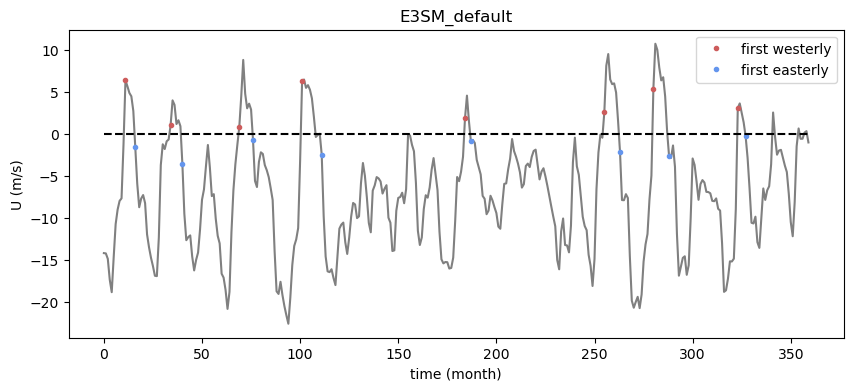

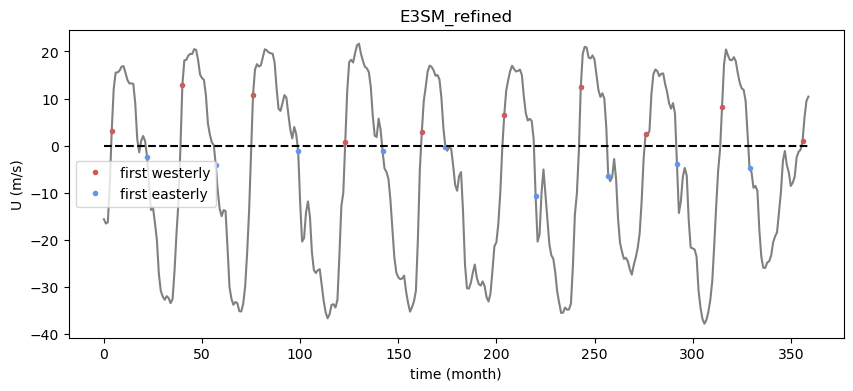

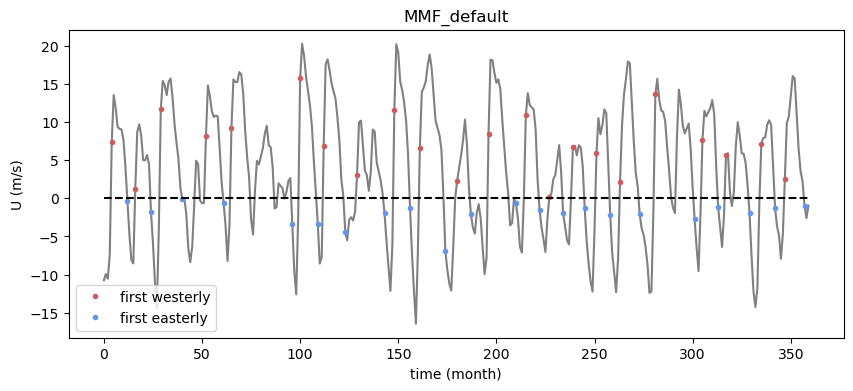

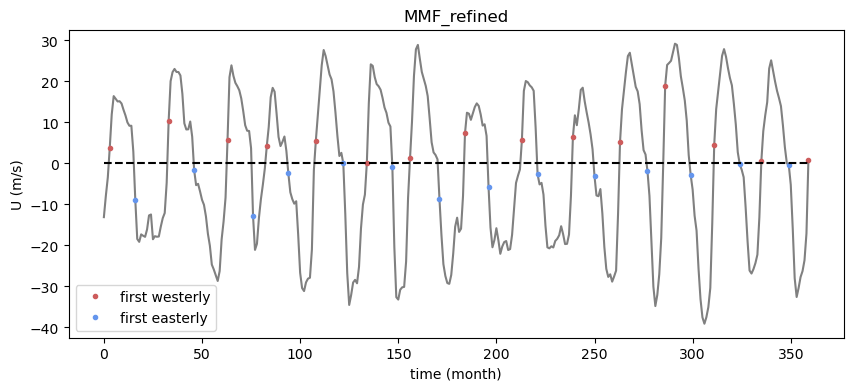

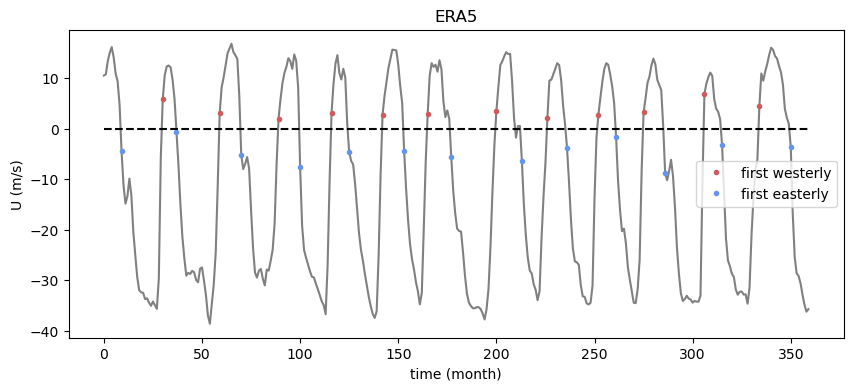

In [16]:

for c,name in enumerate(['E3SM_default','E3SM_refined','MMF_default','MMF_refined','ERA5']): 
    var  = zonal_mean(data[name].sel(lev= 20,method='nearest'), 'u', -5,5).values
    qbo_tt = tt_qbo_statistics(var, 3, test=True)
    plt.title(name)

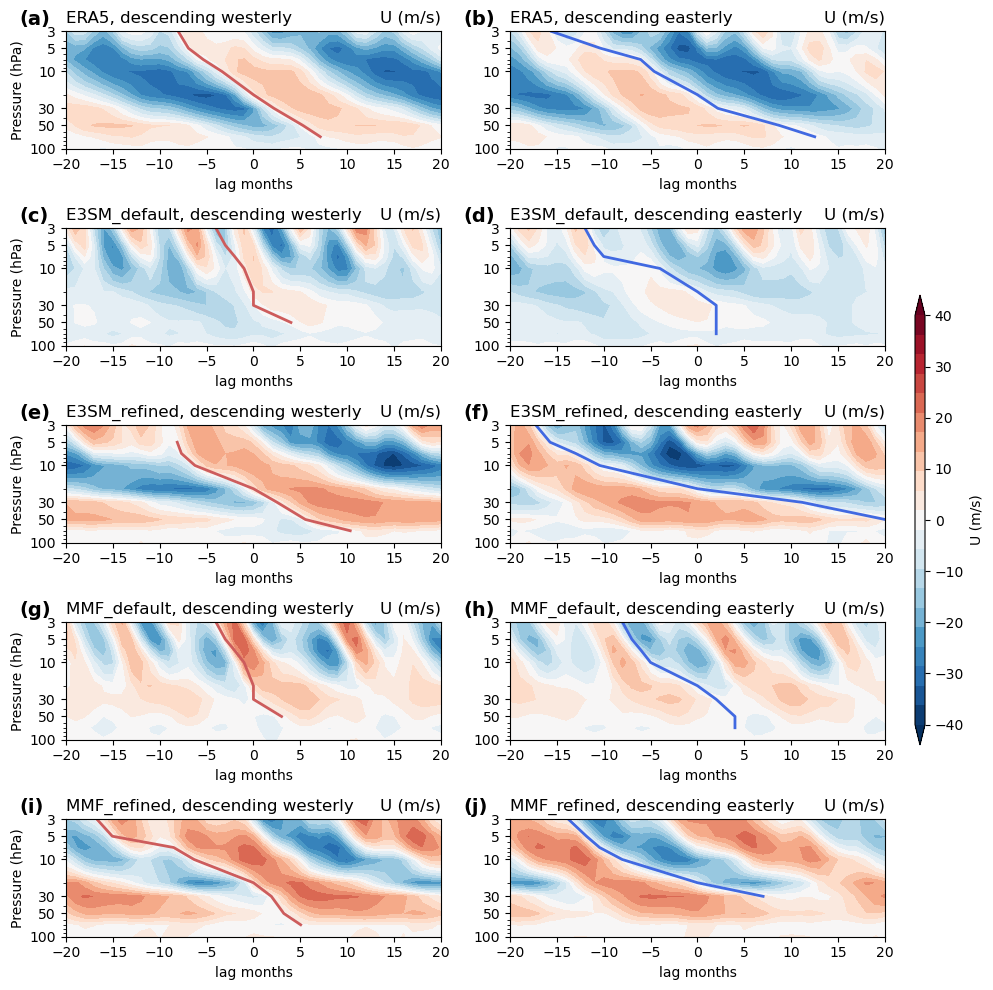

In [75]:

plt.figure(figsize=[10,10])
speeds = {}
for c,name in enumerate(data): 
    speed = []
    for ii in range(2):
        plt.subplot(5,2,c*2+1+ii)
        var  = zonal_mean(data[name].sel(lev=20,method='nearest'), 'u', -5,5).values
        min_period = 3 if c in [0,2] else 3
        qbo_tt = tt_qbo_statistics(var, min_period)
        ttime = qbo_tt['transition_times']

        x  = zonal_mean(data[name], 'u', -5,5)
        cx=plt.contourf(np.arange(-20,21),x.lev,calculate_composite(x,ttime[ii]).T,
                    levels=np.linspace(-40,40,22),cmap='RdBu_r',extend='both')

        linear = False if 'default' in name else True
        descending = transition_point(calculate_composite(x,ttime[ii]),x.lev,linear_fit=linear)-20
        if (name == 'E3SM_refined') and (ii == 1):
            descending[28] = 20
            descending[27] = np.nan
        # if (name == 'E3SM_default') and (j == 0):
        #     descending[33:] = descending[33:]+3
        if (name == 'MMF_refined') and (ii == 1):
            descending[29] = 7
        if (name == 'MMF_default') and (ii == 0):
            descending[27] = np.nan
        descending[np.where(x.lev>90)] = np.nan
        # descending[np.where(x.lev<5)] = np.nan
        plt.plot(descending,x.lev,
                color=['indianred','royalblue'][ii],linewidth=2)
        plt.yscale('log')
        if ii == 0:
            plt.ylabel('Pressure (hPa)')
        plt.ylim([1e2,3])
        case = ['descending westerly','descending easterly'][ii]
        plt.title(f'{name}, {case}',loc='left')
        plt.title('U (m/s)',loc='right')
        plt.xlabel('lag months')
        plt.yticks([100,50,30,10,5,3],[100,50,30,10,5,3])
        add_order(plt.gca(),c*2+ii,-25,2.5)
        speed.append(np.gradient(p2z(x.lev))/np.gradient(descending))
        #speed.append(np.gradient(p2z(x.lev))/np.gradient(descending))
    speeds[name] = speed
import matplotlib.cm as cm
import matplotlib.colorbar as colorbar
import matplotlib.colors as colors
plt.tight_layout()
plt.tight_layout()
plt.subplots_adjust(right=0.89)
cax1 = plt.axes([0.92, 0.25, 0.01, 0.45])
cb1 = plt.colorbar(cx,cax=cax1)
cb1.set_ticks(range(-40,45,10))
cb1.set_label('U (m/s)')
#plt.savefig('figures/u_composite.pdf')

# figures

## figure 1

In [6]:
ver_grid = '/global/u2/w/wandiyu/data_read_and_process/vertical_grid_files/'
file_names = {'E3SM_default':'L72_E3SM'
          , 'E3SM_refined':'L80*E3SM'
    ,'MMF_default': 'L64_MMF'
              ,'MMF_refined':'L72_MMF'
        }

In [7]:
vert_file_list = {}
for name in file_names:
    vert_file_list[name] = glob(ver_grid+file_names[name]+'*')[0]

mlev_list = {}
dlev_list = {}
use_height= True
for name in vert_file_list:

    ds = xr.open_dataset(vert_file_list[name])

    mlev = ds['hyam'].values*1000 + ds['hybm'].values*1000
    ilev = ds['hyai'].values*1000 + ds['hybi'].values*1000

    # rough estimate of height from pressure
    ilevz = np.log(ilev/1e3) * -6740.
    mlevz = np.log(mlev/1e3) * -6740.

    dlevz = mlevz*0.
    for k in range(len(mlev)): dlevz[k] = ilevz[k] - ilevz[k+1]

    if use_height:
        mlev_list[name]=mlevz
        dlev_list[name]=dlevz
    else:
        mlev_list[name]=mlev
        dlev_list[name]=dlevz

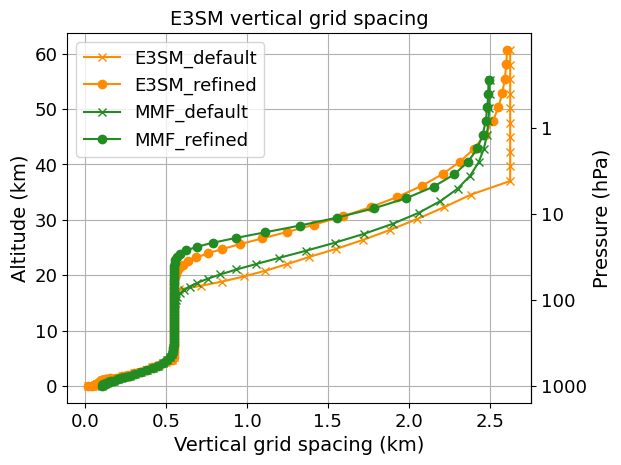

In [17]:
for name in file_names:
    plt.plot(dlev_list[name]/1000,mlev_list[name]/1000
            ,marker=markers[name],label=name,
               color = data_colors[name],)
# plt.ylim([1000,1])
# plt.yscale('log')
plt.ylabel('Altitude (km)',fontsize=14)
plt.legend(fontsize=13)
plt.xlabel('Vertical grid spacing (km)',fontsize=14)
plt.title('E3SM vertical grid spacing',fontsize=14)
plt.grid(True)
plt.xticks(fontsize=13)
plt.yticks(range(0,65,10),fontsize=13)
# Create a secondary y-axis for altitude
secax = plt.gca().secondary_yaxis('right', functions=(z2p,p2z))
secax.minorticks_off()

# Set the y-ticks and labels for the altitude axis
ticks=range(3,-10,-1)
secax.set_yticks([(int((10**(i)))) for i in ticks],[(int((10**(i)))) for i in ticks],fontsize=13);
secax.set_ylabel('Pressure (hPa)',fontsize=14)
plt.subplots_adjust(right=0.85)
plt.savefig('figures/vertical_grid.pdf')

## figure 2

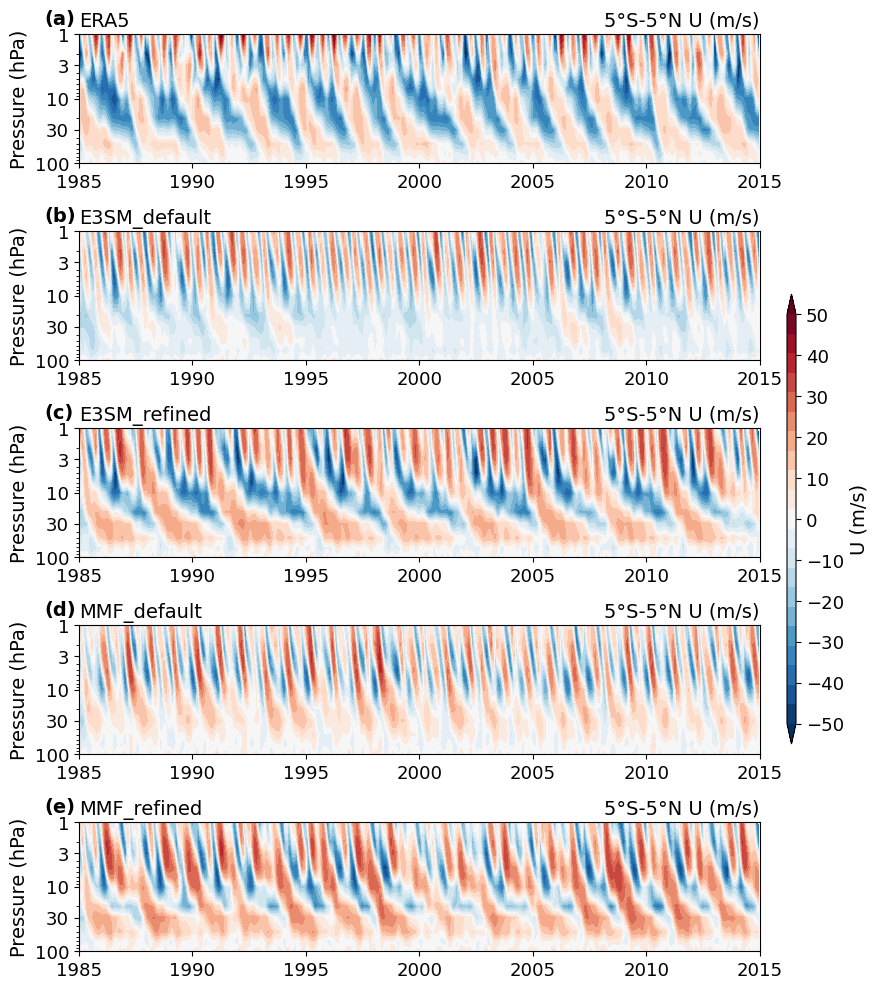

In [18]:
plt.figure(figsize=[9,10])
for i,name in enumerate(data):
    plt.subplot(5,1,i+1)
    x  = zonal_mean(data[name], 'u', -5,5)
    cx=plt.contourf(np.arange(1985,2015,1/12), x.lev.values, x.values.T,
                levels=np.linspace(-50,50,22),cmap='RdBu_r',extend='both')

    plt.ylim([100,1])
    plt.yscale('log')
    plt.ylabel('Pressure (hPa)',fontsize=14)
    plt.title(f'{name}', loc='left',fontsize=14)
    plt.title('5°S-5°N U (m/s)',loc='right',fontsize=14)
    plt.yticks([100,30,10,3,1],[100,30,10,3,1],fontsize=13)
    plt.xticks(range(1985,2020,5),fontsize=13)
    add_order(plt.gca(),i,1983.5,0.7)
    
import matplotlib.cm as cm
import matplotlib.colorbar as colorbar
import matplotlib.colors as colors
plt.tight_layout()
plt.subplots_adjust(right=0.85)
cax1 = plt.axes([0.88, 0.25, 0.01, 0.45])
cb1 = plt.colorbar(cx,cax=cax1)
cb1.set_ticks(range(-50,55,10))
cb1.ax.tick_params(labelsize=13)
cb1.set_label('U (m/s)',fontsize=14)
plt.savefig('figures/hov.pdf')

## figure 3

In [17]:
lat1,lat2 = -5,5
pow_spec_lev = 20.
var = ['u']

#---------------------------------------------------------------------------------------------------
# calculate some things that will be needed below
period = np.concatenate( (np.arange(2.0, 33.0), np.arange(34.0, 100.0, 2.0)), axis=0 )
period = xr.DataArray(period, coords={'period':period}).assign_attrs({'units':'months'})
#--

In [18]:
data_pow_spec = {}
data_amp_prof = {}
for name in data:
    # Calculate quantities of interest
    data_avg = zonal_mean(data[name], 'u', -5,5)
    psd, pow_spec = get_psd_from_deseason(data_avg.sel(lev=pow_spec_lev,method='nearest').values, period.values)
    psd, amp_prof = get_20to40month_fft_amplitude(data_avg.values, data_avg.lev.values, period1 = 20, period2 = 50)
    # convert to xarray DataArray
    data_pow_spec[name] = xr.DataArray( pow_spec, coords=[period] )
    data_amp_prof[name] = xr.DataArray( amp_prof, coords=[data_avg.lev.assign_attrs({'units':'mb'})] )


In [19]:
5*12/8

7.5

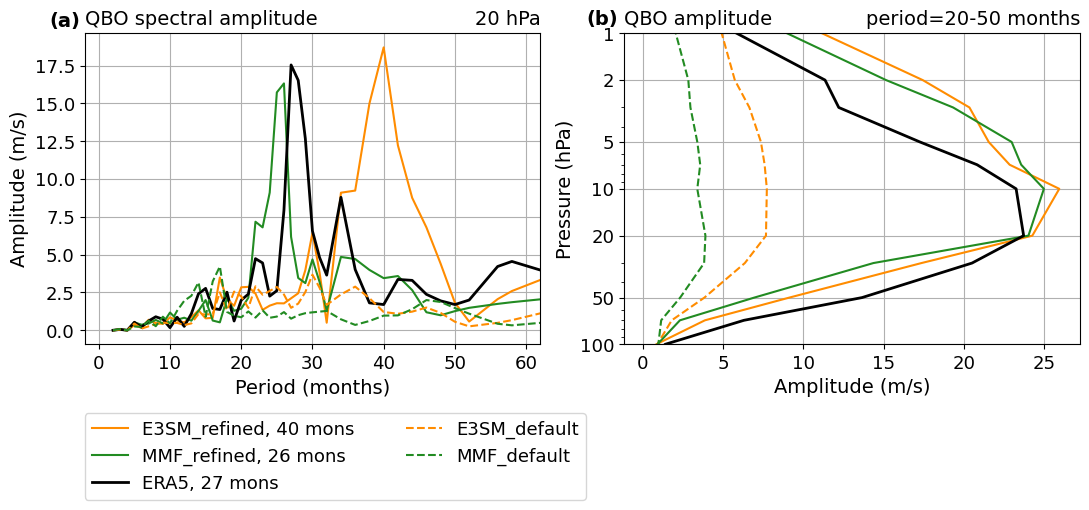

In [22]:
plt.figure(figsize=[11,6],layout='constrained')

plt.subplot(1,2,2)
for name in ['E3SM_refined','E3SM_default', 'MMF_refined', 'MMF_default', 'ERA5']:
    linewidth = 2 if name == 'ERA5' else 1.5
    plt.plot(data_amp_prof[name].values, data_amp_prof[name].lev.values,
             label=name,color = data_colors[name], linewidth=linewidth,
            linestyle = linestyles[name])
#plt.legend(ncol=2)
plt.yscale('log')
plt.ylabel('Pressure (hPa)',fontsize=14)
plt.ylim([1e2,1e0])
plt.xlabel('Amplitude (m/s)',fontsize=14)
plt.title('QBO amplitude',loc='left',fontsize=14)
plt.title('period=20-50 months', loc='right',fontsize=14)
plt.grid(True)
plt.xticks(fontsize=13)
plt.yticks([100,50,20,10,5,2,1],[100,50,20,10,5,2,1],fontsize=13)
add_order(plt.gca(),1,-3.5,0.88)

plt.subplot(1,2,1)
for name in ['E3SM_refined','MMF_refined','ERA5','E3SM_default',  'MMF_default']:
    linewidth = 2 if name == 'ERA5' else 1.5
    max_period = np.round(data_pow_spec[name].period[np.where(data_pow_spec[name].values == data_pow_spec[name].max().values)].values)[0]
    if 'default' in name:
        plt.plot(data_pow_spec[name].period.values,data_pow_spec[name].values, 
             label=f'{name}',color = data_colors[name], linewidth=linewidth,
            linestyle = linestyles[name])
    else:
        plt.plot(data_pow_spec[name].period.values,data_pow_spec[name].values, 
             label=f'{name}, {int(max_period)} mons',color = data_colors[name], linewidth=linewidth,
            linestyle = linestyles[name])
plt.xlabel('Period (months)',fontsize=14)
plt.xlim([-2,62])
plt.ylabel('Amplitude (m/s)',fontsize=14)
plt.legend(ncol=2)
plt.legend(bbox_to_anchor=(0., -0.5, 1.1, .102), loc='lower left',
           ncols=2, mode="expand", borderaxespad=0.,fontsize=13)

plt.xticks(range(0,61,10),fontsize=13)
plt.yticks(fontsize=13)
plt.title('QBO spectral amplitude',loc='left',fontsize=14)
plt.title('20 hPa',loc='right',fontsize=14)
plt.grid(True)
plt.tight_layout()
add_order(plt.gca(),0,-7,20.1)
plt.savefig('figures/amplitude_density.pdf')


## figure 4

In [22]:
lats = np.arange(-30,35,5)
amp_prof_lat = {}
for name in data: 
    amp_prof_all = np.zeros([len(lats),len(data_amp_prof[name].values)])
    for i,ilat in enumerate(lats):    
        lat1,lat2 = ilat-5,ilat+5
        data_avg = zonal_mean(data[name], 'u', lat1,lat2)
        psd, amp_prof_all[i] = get_20to40month_fft_amplitude(data_avg.values, data_avg.lev.values,
                                                             period1 = 20, period2 = 50)
        
    amp_prof_lat[name] = amp_prof_all

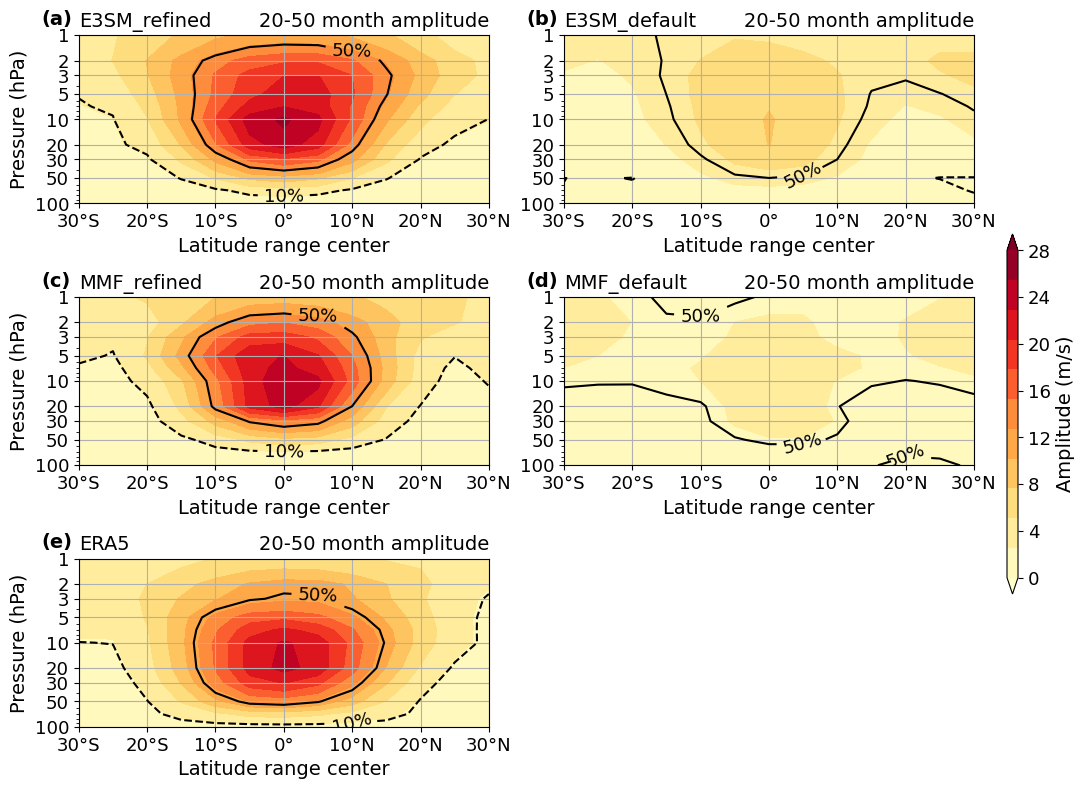

In [24]:
plt.figure(figsize=[11,8])
for c,name in enumerate(['E3SM_refined','E3SM_default', 'MMF_refined', 'MMF_default', 'ERA5']): 
    plt.subplot(3,2,c+1)
    plt.ylim([1e2,1e0])
    def fmt(x):
        if x == amp_prof_lat[name].max()*0.1:
            return '10%'
        elif x == amp_prof_lat[name].max()*0.5:
            return '50%'
    cx = plt.contourf(lats,data[name].lev.values,amp_prof_lat[name].T,cmap='YlOrRd',
                levels=np.linspace(0,28,12),extend='both')
    CS=plt.contour(lats,data[name].lev.values,amp_prof_lat[name].T,levels=[amp_prof_lat[name].max()* ii for ii in [0.5]], colors='k')
    plt.clabel(CS, CS.levels, fmt=fmt,inline=True,fontsize=13)
    CS=plt.contour(lats,data[name].lev.values,amp_prof_lat[name].T,levels=[amp_prof_lat[name].max()* ii for ii in [0.1]], colors='k',
                  linestyles='--')
    plt.clabel(CS, CS.levels, fmt=fmt,inline=True,fontsize=13)
    #plt.gca().xaxis.set_major_formatter(print_lat)
    plt.xticks(plt.gca().get_xticks(), [print_lat(x) for x in plt.gca().get_xticks()]
              ,fontsize=13)
    plt.yscale('log')
    if c%2 == 0:
        plt.ylabel('Pressure (hPa)',fontsize=14)
    plt.xlabel('Latitude range center',fontsize=14)
    plt.title(f'{name}',loc='left',fontsize=14)
    plt.title('20-50 month amplitude',loc='right',fontsize=14)
    plt.grid(True)
    plt.yticks([100,50,30,20,10,5,3,2,1],[100,50,30,20,10,5,3,2,1],fontsize=13)
    add_order(plt.gca(),c,-35.5,0.75)
import matplotlib.cm as cm
import matplotlib.colorbar as colorbar
import matplotlib.colors as colors
plt.tight_layout()
plt.subplots_adjust(right=0.89)
cax1 = plt.axes([0.92, 0.25, 0.01, 0.45])
cb1 = plt.colorbar(cx,cax=cax1)
cb1.set_ticks(range(0,29,4))
cb1.ax.tick_params(labelsize=13)
cb1.set_label('Amplitude (m/s)',fontsize=14)
plt.savefig('figures/amplitude.pdf')

## figure 5

In [20]:
descent_n_mean = {}
descent_p_mean = {}
descent_n_std = {}
descent_p_std = {}
levs = np.array([100,  70.,   50.,   30., 
         20.,   10.,    7.,    5.,    3.,    2.,    1.]) # add 100 as the -1 element 
levs_mid = (np.array([100,  70.,   50.,   30., 
         20.,   10.,    7.,    5.,    3.,    2.,   ]) + np.array([70.,   50.,   30., 
         20.,   10.,    7.,    5.,    3.,    2.,    1.]))/2
for c,name in enumerate(data):
    levs_mid  = []
    descent_n_case_mean = np.ones(len(levs)-1)*np.nan
    descent_p_case_mean = np.ones(len(levs)-1)*np.nan
    descent_n_case_std = np.ones(len(levs)-1)*np.nan
    descent_p_case_std = np.ones(len(levs)-1)*np.nan
    for i in range(len(levs[:-1])):  
        lev_u,lev_l = levs[i+1],levs[i]
        levs_mid.append((lev_u+lev_l)/2)
        dzdt_e2w, dzdt_w2e = decent_speed(data[name], lev_u,lev_l)
        if len(dzdt_w2e)>3:
            descent_n_case_mean[i] = np.mean(dzdt_w2e)
            descent_n_case_std[i] = np.std(dzdt_w2e)
        if len(dzdt_e2w)>3:
            descent_p_case_mean[i] = np.mean(dzdt_e2w)
            descent_p_case_std[i] = np.std(dzdt_e2w)
    descent_n_mean[name] = descent_n_case_mean
    descent_p_mean[name] = descent_p_case_mean
    descent_n_std[name] = descent_n_case_std
    descent_p_std[name] = descent_p_case_std

In [21]:
duration_n_mean = {}
duration_p_mean = {}
duration_n_std = {}
duration_p_std = {}
levs = np.array([70.,   50.,   30.,
         20.,   10.,    7.,    5.,    3.,    2.,    1.])
for c,name in enumerate(data):
    duration_n_case_mean = np.zeros(len(levs))
    duration_p_case_mean = np.zeros(len(levs))
    duration_n_case_std = np.zeros(len(levs))
    duration_p_case_std = np.zeros(len(levs))
    for i,ilev in enumerate(levs):  
        var  = zonal_mean(data[name].sel(lev= ilev,method='nearest'), 'u', -5,5).values
        qbo_tt = tt_qbo_statistics(var, min_period=3)
        duration_n_case_mean[i] = np.mean(qbo_tt['duration'][0])
        duration_p_case_mean[i] = np.mean(qbo_tt['duration'][1])
        duration_n_case_std[i] = np.std(qbo_tt['duration'][0])
        duration_p_case_std[i] = np.std(qbo_tt['duration'][1])
    duration_n_mean[name] = duration_n_case_mean
    duration_p_mean[name] = duration_p_case_mean
    duration_n_std[name] = duration_n_case_std
    duration_p_std[name] = duration_p_case_std

In [22]:
amp_n_mean = {}
amp_p_mean = {}
amp_n_std = {}
amp_p_std = {}
levs = np.array([70.,   50.,   30.,
         20.,   10.,    7.,    5.,    3.,    2.,    1.])
for c,name in enumerate(data):
    amp_n_case_mean = np.zeros(len(levs))
    amp_p_case_mean = np.zeros(len(levs))
    amp_n_case_std = np.zeros(len(levs))
    amp_p_case_std = np.zeros(len(levs))
    for i,ilev in enumerate(levs):  
        var  = zonal_mean(data[name].sel(lev= ilev,method='nearest'), 'u', -5,5).values
        qbo_tt = tt_qbo_statistics(var, min_period=3)
        amp_n_case_mean[i] = -np.mean(qbo_tt['amplitude'][0])
        amp_p_case_mean[i] = np.mean(qbo_tt['amplitude'][1])
        amp_n_case_std[i] = np.std(qbo_tt['amplitude'][0])
        amp_p_case_std[i] = np.std(qbo_tt['amplitude'][1])
    amp_n_mean[name] = amp_n_case_mean
    amp_p_mean[name] = amp_p_case_mean
    amp_n_std[name] = amp_n_case_std
    amp_p_std[name] = amp_p_case_std

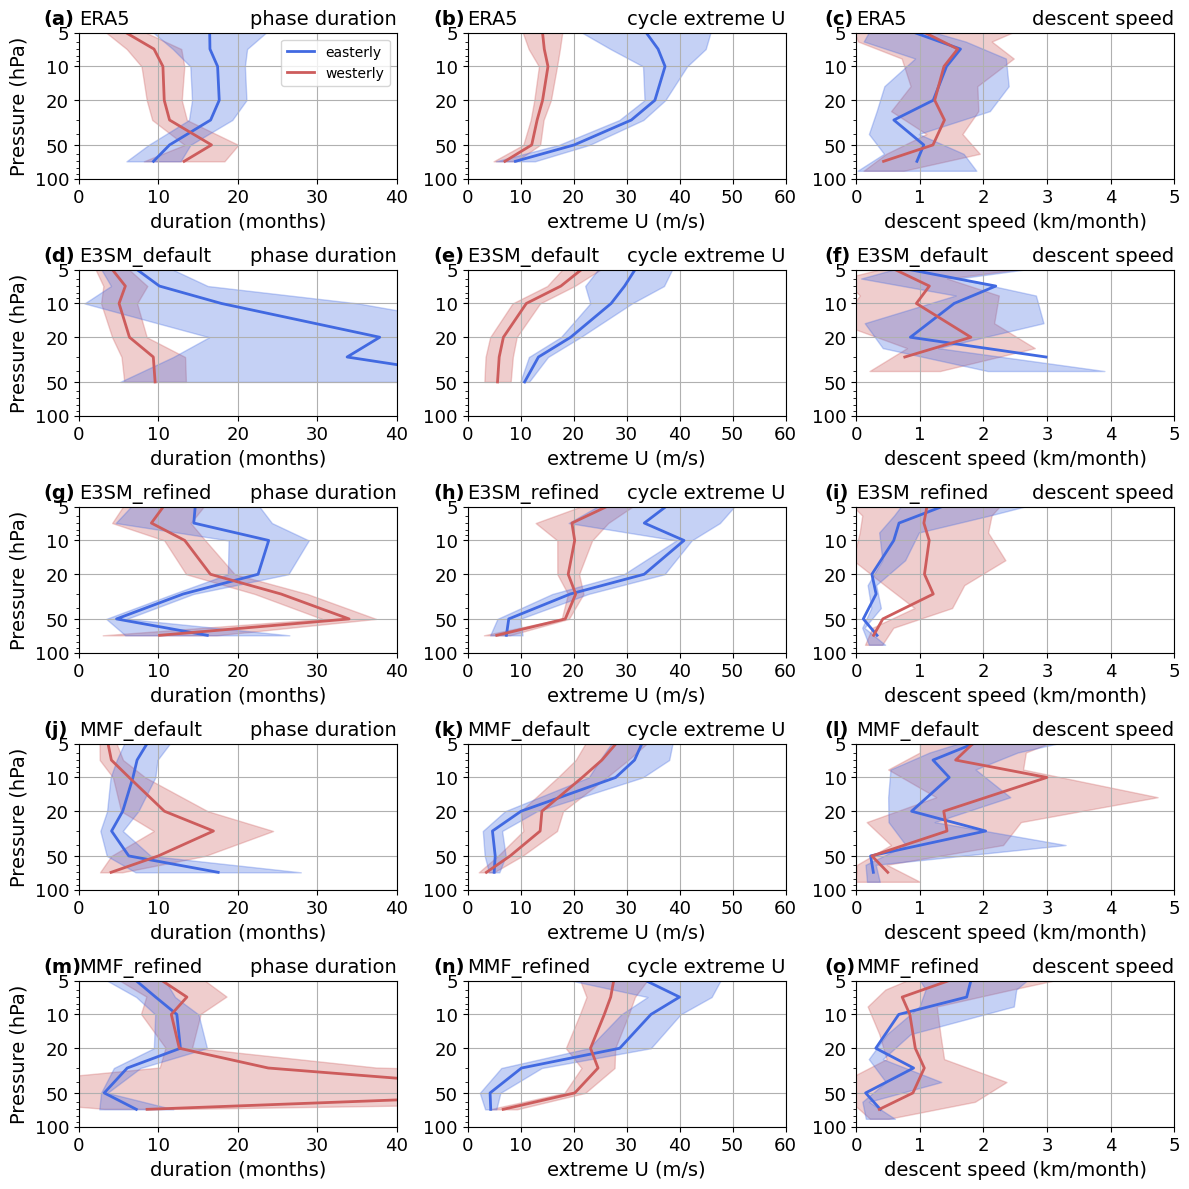

In [23]:

plt.figure(figsize=[12,12])
for i,c in enumerate(data): 
    plt.subplot(5,3,i*3+1)
    plt.plot(duration_n_mean[c],levs,color='royalblue',label='easterly',
            linewidth=2)
    plt.plot(duration_p_mean[c],levs,color='indianred',label='westerly',
            linewidth=2)
    plt.fill_betweenx(levs,duration_p_mean[c]+duration_p_std[c],
            duration_p_mean[c]-duration_p_std[c],color='indianred',
                     alpha = 0.3)
    plt.fill_betweenx(levs,duration_n_mean[c]+duration_n_std[c],
            duration_n_mean[c]-duration_n_std[c],color='royalblue',
                     alpha = 0.3)
    if i == 0:
        plt.legend()
    plt.title(c,loc='left',fontsize=14)
    plt.xlim([0,40])
    plt.yscale('log')
    plt.ylabel('Pressure (hPa)',fontsize=14)
    plt.ylim([1e2,5])
    plt.xlabel('duration (months)',fontsize=14)
    plt.title('phase duration', loc='right',fontsize=14)
    plt.grid(True)
    plt.xticks(fontsize=13)
    plt.yticks([100,50,20,10,5],[100,50,20,10,5],fontsize=13)
    add_order(plt.gca(),i*3,-4.5,4.25)


for i,c in enumerate(data): 
    plt.subplot(5,3,i*3+2)
    plt.plot(amp_n_mean[c],levs,color='royalblue',label='easterly',
            linewidth=2)
    plt.plot(amp_p_mean[c],levs,color='indianred',label='westerly',
            linewidth=2)
    plt.fill_betweenx(levs,amp_p_mean[c]+amp_p_std[c],
            amp_p_mean[c]-amp_p_std[c],color='indianred',
                     alpha = 0.3)
    plt.fill_betweenx(levs,amp_n_mean[c]+amp_n_std[c],
            amp_n_mean[c]-amp_n_std[c],color='royalblue',
                     alpha = 0.3)
    plt.title(c,loc='left',fontsize=14)
    plt.xlim([0,60])
    plt.yscale('log')
    plt.ylim([1e2,5e0])
    plt.xlabel('extreme U (m/s)',fontsize=14)
    plt.title('cycle extreme U', loc='right',fontsize=14)
    plt.grid(True)
    plt.xticks(fontsize=13)
    plt.yticks([100,50,20,10,5],[100,50,20,10,5],fontsize=13)
    add_order(plt.gca(),i*3+1,-6.5,4.25)

for i,c in enumerate(data): 
    plt.subplot(5,3,i*3+3)
    plt.plot(descent_n_mean[c],levs,color='royalblue',label='easterly',
            linewidth=2)
    plt.plot(descent_p_mean[c],levs,color='indianred',label='westerly',
            linewidth=2)
    plt.fill_betweenx(levs_mid,descent_p_mean[c]+descent_p_std[c],
            descent_p_mean[c]-descent_p_std[c],color='indianred',
                     alpha = 0.3)
    plt.fill_betweenx(levs_mid,descent_n_mean[c]+descent_n_std[c],
            descent_n_mean[c]-descent_n_std[c],color='royalblue',
                     alpha = 0.3)
    plt.title(c,loc='left',fontsize=14)
    plt.xlim([0,5])
    plt.yscale('log')
    plt.ylim([1e2,5e0])
    plt.xlabel('descent speed (km/month)',fontsize=14)
    plt.title('descent speed', loc='right',fontsize=14)
    plt.grid(True)
    plt.xticks(fontsize=13)
    plt.yticks([100,50,20,10,5],[100,50,20,10,5],fontsize=13)
    add_order(plt.gca(),i*3+2,-0.5,4.25)
    
plt.tight_layout()
plt.savefig('figures/asymmetry.pdf',transparent=True)

## figure 10

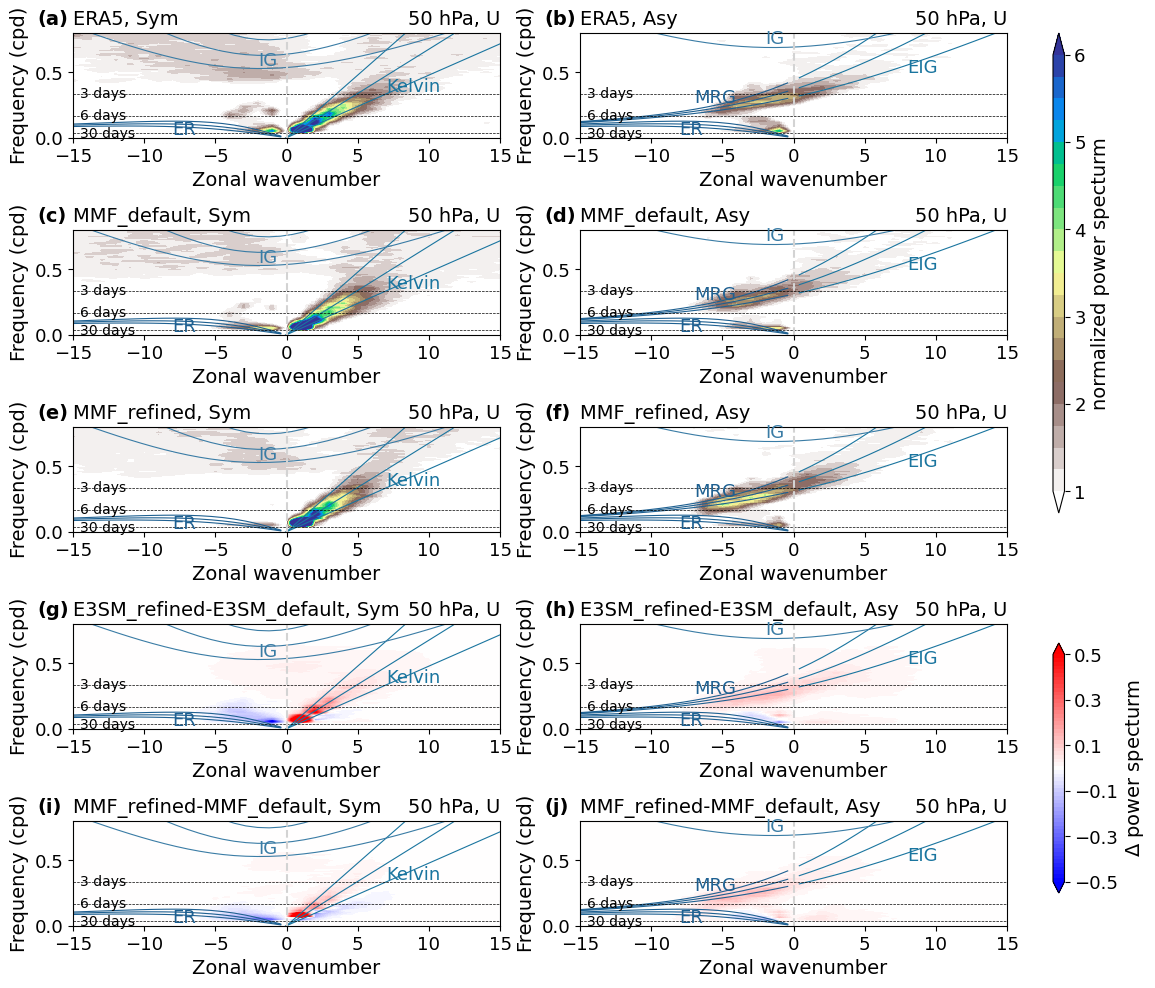

In [70]:
name = 'ERA5'
plt.figure(figsize=[11.5,10])
ilev = '50'
for i,name in enumerate(['ERA5','MMF_default','MMF_refined']):
    plt.subplot(5,2,1+i*2)
        
    img = plot_normalized_spectrum(wk_data[name]['nspec_sym']/wk_data[name]['background']
                                 ,'Symmetric',left_title=f'{name}, Sym',
                                   right_title = f"{ilev} hPa, U",
                                 cmap='terrain_r',levels=np.linspace(1,6,21),
                                      colorbar=False)
    add_order(plt.gca(),i*2,-17.5,0.86)
    plt.subplot(5,2,2+i*2)
    img = plot_normalized_spectrum(wk_data[name]['nspec_asy']/wk_data[name]['background']
                                 ,'Asymmetric',left_title=f'{name}, Asy',
                                   right_title = f"{ilev} hPa, U",
                                 cmap='terrain_r',levels=np.linspace(1,6,21),
                                      colorbar=False)
    add_order(plt.gca(),i*2+1,-17.5,0.86)

plt.subplot(5,2,7)
img2 = plot_normalized_spectrum(wk_data['E3SM_refined']['nspec_sym']-wk_data['E3SM_default']['nspec_sym']
                             ,'Symmetric',left_title=f'E3SM_refined-E3SM_default, Sym',
                               right_title = f"{ilev} hPa, U",
                             cmap='bwr',levels=np.linspace(-0.5,0.5,62),
                                  colorbar=False)
add_order(plt.gca(),6,-17.5,0.86)

plt.subplot(5,2,8)
img2 = plot_normalized_spectrum(wk_data['E3SM_refined']['nspec_asy']-wk_data['E3SM_default']['nspec_asy']
                             ,'Asymmetric',left_title=f'E3SM_refined-E3SM_default, Asy',
                               right_title = f"{ilev} hPa, U",
                             cmap='bwr',levels=np.linspace(-0.5,0.5,62),
                                  colorbar=False)
add_order(plt.gca(),7,-17.5,0.86)


plt.subplot(5,2,9)
img2 = plot_normalized_spectrum(wk_data['MMF_refined']['nspec_sym']-wk_data['MMF_default']['nspec_sym']
                             ,'Symmetric',left_title=f'MMF_refined-MMF_default, Sym',
                               right_title = f"{ilev} hPa, U",
                             cmap='bwr',levels=np.linspace(-0.5,0.5,62),
                                  colorbar=False)
add_order(plt.gca(),8,-17.5,0.86)

plt.subplot(5,2,10)
img2 = plot_normalized_spectrum(wk_data['MMF_refined']['nspec_asy']-wk_data['MMF_default']['nspec_asy']
                             ,'Asymmetric',left_title=f'MMF_refined-MMF_default, Asy',
                               right_title = f"{ilev} hPa, U",
                             cmap='bwr',levels=np.linspace(-0.5,0.5,62),
                                  colorbar=False)
add_order(plt.gca(),9,-17.5,0.86)

plt.tight_layout()
import matplotlib.cm as cm
import matplotlib.colorbar as colorbar
import matplotlib.colors as colors

plt.subplots_adjust(right=0.88)
cax1 = plt.axes([0.92, 0.48, 0.01, 0.48])
cb1 = plt.colorbar(img,cax=cax1)
cb1.set_ticks(np.arange(1,7,1))
cb1.ax.tick_params(labelsize=13)
cb1.set_label('normalized power specturm',fontsize=14)

cax1 = plt.axes([0.92, 0.1, 0.01, 0.25])
cb1 = plt.colorbar(img2,cax=cax1)
cb1.set_ticks(np.arange(-0.5,0.6,0.2))
cb1.ax.tick_params(labelsize=13)
cb1.set_label(r'$\Delta$ power specturm',fontsize=14)
plt.savefig('figures/wk_mmf.pdf')

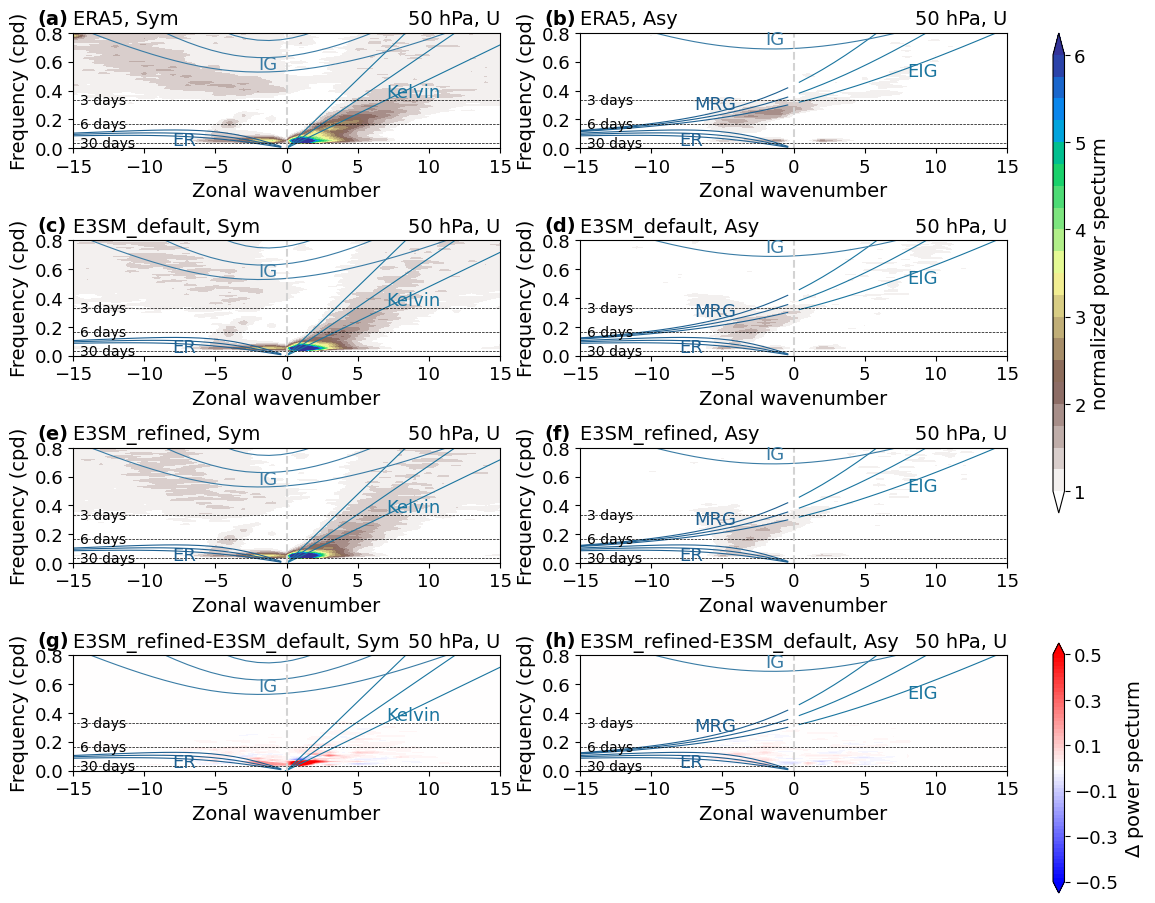

In [27]:
name = 'ERA5'
plt.figure(figsize=[11.5,10])
ilev = '50'
for i,name in enumerate(['ERA5','E3SM_default','E3SM_refined']):
    plt.subplot(5,2,1+i*2)
        
    img = plot_normalized_spectrum(wk_data[name]['nspec_sym']/wk_data[name]['background']
                                 ,'Symmetric',left_title=f'{name}, Sym',
                                   right_title = f"{ilev} hPa, U",
                                 cmap='terrain_r',levels=np.linspace(1,6,21),
                                      colorbar=False)
    add_order(plt.gca(),i*2,-17.5,0.86)
    plt.subplot(5,2,2+i*2)
    img = plot_normalized_spectrum(wk_data[name]['nspec_asy']/wk_data[name]['background']
                                 ,'Asymmetric',left_title=f'{name}, Asy',
                                   right_title = f"{ilev} hPa, U",
                                 cmap='terrain_r',levels=np.linspace(1,6,21),
                                      colorbar=False)
    add_order(plt.gca(),i*2+1,-17.5,0.86)

plt.subplot(5,2,7)
img2 = plot_normalized_spectrum(wk_data['E3SM_refined']['nspec_sym']-wk_data['E3SM_default']['nspec_sym']
                             ,'Symmetric',left_title=f'E3SM_refined-E3SM_default, Sym',
                               right_title = f"{ilev} hPa, U",
                             cmap='bwr',levels=np.linspace(-0.5,0.5,62),
                                  colorbar=False)
add_order(plt.gca(),6,-17.5,0.86)

plt.subplot(5,2,8)
img2 = plot_normalized_spectrum(wk_data['E3SM_refined']['nspec_asy']-wk_data['E3SM_default']['nspec_asy']
                             ,'Asymmetric',left_title=f'E3SM_refined-E3SM_default, Asy',
                               right_title = f"{ilev} hPa, U",
                             cmap='bwr',levels=np.linspace(-0.5,0.5,62),
                                  colorbar=False)
add_order(plt.gca(),7,-17.5,0.86)


# plt.subplot(5,2,9)
# img2 = plot_normalized_spectrum(wk_data['MMF_refined']['nspec_sym']-wk_data['MMF_default']['nspec_sym']
#                              ,'Symmetric',left_title=f'MMF_refined-MMF_default, Sym',
#                                right_title = f"{ilev} hPa, U",
#                              cmap='bwr',levels=np.linspace(-0.5,0.5,62),
#                                   colorbar=False)
# add_order(plt.gca(),8,-17.5,0.86)

# plt.subplot(5,2,10)
# img2 = plot_normalized_spectrum(wk_data['MMF_refined']['nspec_asy']-wk_data['MMF_default']['nspec_asy']
#                              ,'Asymmetric',left_title=f'MMF_refined-MMF_default, Asy',
#                                right_title = f"{ilev} hPa, U",
#                              cmap='bwr',levels=np.linspace(-0.5,0.5,62),
#                                   colorbar=False)
# add_order(plt.gca(),9,-17.5,0.86)

plt.tight_layout()
import matplotlib.cm as cm
import matplotlib.colorbar as colorbar
import matplotlib.colors as colors

plt.subplots_adjust(right=0.88)
cax1 = plt.axes([0.92, 0.48, 0.01, 0.48])
cb1 = plt.colorbar(img,cax=cax1)
cb1.set_ticks(np.arange(1,7,1))
cb1.ax.tick_params(labelsize=13)
cb1.set_label('normalized power specturm',fontsize=14)

cax1 = plt.axes([0.92, 0.1, 0.01, 0.25])
cb1 = plt.colorbar(img2,cax=cax1)
cb1.set_ticks(np.arange(-0.5,0.6,0.2))
cb1.ax.tick_params(labelsize=13)
cb1.set_label(r'$\Delta$ power specturm',fontsize=14)
#plt.savefig('figures/wk.pdf')

## figure 6 & 8

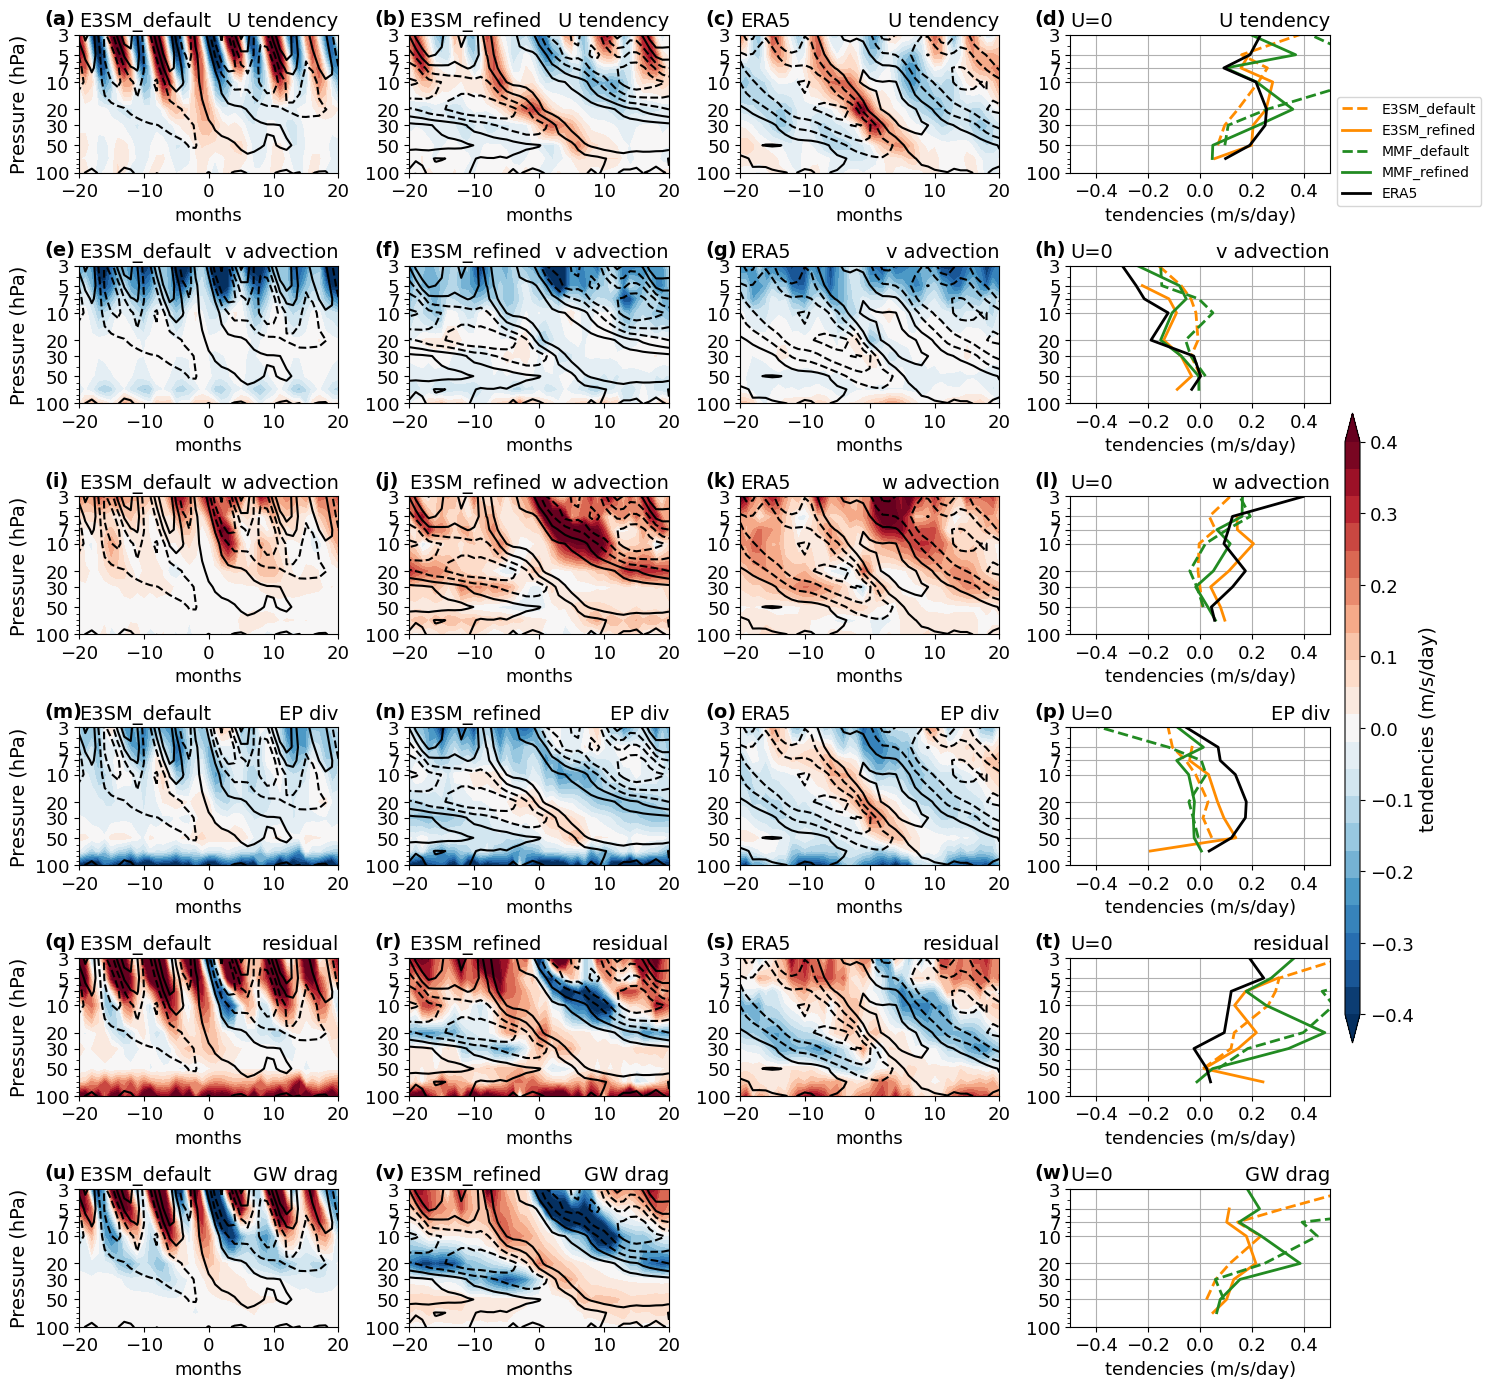

In [76]:
plt.figure(figsize=[15,14])
j = 0
for ii in range(6):
    descending_vars = []
    ifig = 0
    for c,name in enumerate(['E3SM_default','E3SM_refined','MMF_default','MMF_refined','ERA5']): 
        
        var  = zonal_mean(data[name].sel(lev= 20,method='nearest'), 'u', -5,5).values
        qbo_tt = tt_qbo_statistics(var, 3)
        ttime = qbo_tt['transition_times']
        x  = zonal_mean(data[name], 'u', -5,5)
        v1 = data[name]['u'].differentiate(coord='time',datetime_unit='s')
        v2 = data[name]['utendvtem']
        v3 = data[name]['utendwtem']
        v4 = data[name]['utendepfd']
        v5 = v1-(v2+v3+v4)

        if ii == 0:
            var = v1
        elif ii == 1:
            var = v2
        elif ii == 2:
            var = v3
        elif ii == 3:
            var = v4
        elif ii == 4:
            var = v5
        else:
            if c == 4:
                continue 
            else:
                var = (data[name]['UTGWSPEC']+data[name]['BUTGWSPEC']+data[name]['UTGWORO'])
        
        x = xr.Dataset()
        x['x'] = var
        x  = zonal_mean(x, 'x', -5,5)
        composite = calculate_composite(x,ttime[j])*86400
        if c in [0,1,4]:
            ifig+=1
            plt.subplot(6,4,ifig+ii*4)
            cx=plt.contourf(np.arange(-20,21),x.lev,composite.T,
                        levels=np.linspace(-0.4,0.4,22),cmap='RdBu_r',extend='both')
            x  = zonal_mean(data[name], 'u', -5,5)
            plt.contour(np.arange(-20,21),x.lev,calculate_composite(x,ttime[j]).T
                        ,colors='k',levels=np.arange(-30,35,10))        
            plt.yscale('log')

            if c == 0:
                plt.ylabel('Pressure (hPa)',fontsize=14)
            plt.ylim([100,3])
            titles = ['U tendency','v advection','w advection', 'EP div', 'residual','GW drag']
            plt.title(f'{name}',loc='left',fontsize=14)
            plt.title(f'{titles[ii]}',loc='right',fontsize=14)
            plt.xlabel('months',fontsize=13)
            plt.yticks([100,50,30,20,10,7,5,3],[100,50,30,20,10,7,5,3],fontsize=13)
            plt.xticks(fontsize=13)
            add_order(plt.gca(),ifig-1+ii*4,-25.3,2.3)
            
        x  = zonal_mean(data[name], 'u', -5,5)
        descending = transition_point(calculate_composite(x,ttime[j]),x.lev)
        if (name == 'E3SM_refined') and (j == 1):
            descending[28] = 20
            descending[27] = np.nan
        if (name == 'E3SM_default') and (j == 0):
            descending[33:] = descending[33:]+3
        if (name == 'MMF_refined') and (j == 1):
            descending[29] = 5
        if (name == 'MMF_default') and (j == 0):
            descending[27] = np.nan
        descending[np.where(x.lev>90)] = np.nan
        descending_var = np.ones(composite.shape[1])*np.nan
        for ilev in range(composite.shape[1]):
            if np.isfinite(descending[ilev]):
                itime = int(np.round(descending[ilev]))
                descending_var[ilev] = composite[itime,ilev]
        descending_vars.append(descending_var)
        
    plt.subplot(6,4,4+ii*4)
    for c in range(len(descending_vars)):
        run = ['E3SM_default','E3SM_refined','MMF_default','MMF_refined','ERA5'][c]
        plt.plot(descending_vars[c],x.lev,
                color=data_colors[run],linewidth=2,
                label=run,
                linestyle=linestyles[run])
    plt.yscale('log')
    # if (ii == 0) and (j==0):
    #     plt.legend()
    # if (ii == 2) and (j==1):
    #     plt.legend()
    if ii==0:
        # if j == 0:
        #     plt.legend(bbox_to_anchor=(1, 0.1))
        # if j == 1:
        plt.legend(bbox_to_anchor=(1, 0.6))
    plt.xlabel('tendencies (m/s/day)',fontsize=13)
    plt.yticks([100,50,30,20,10,7,5,3],[100,50,30,20,10,7,5,3],fontsize=13)
    plt.xticks(fontsize=13)
    plt.ylim([100,3])
    plt.xlim([-0.5,0.5])
    plt.grid(True)
    plt.title(f'U=0',loc='left',fontsize=14)
    plt.title(f'{titles[ii]}',loc='right',fontsize=14)
    if ii == 5:
        add_order(plt.gca(),2+ii*4,-0.64,2.3)
    else:
        add_order(plt.gca(),2+ii*4+1,-0.64,2.3)
    
plt.tight_layout()
plt.subplots_adjust(right=0.89)
cax1 = plt.axes([0.9, 0.25, 0.01, 0.45])
cb1 = plt.colorbar(cx,cax=cax1)
cb1.set_ticks(np.arange(-0.4,0.5,0.1))
cb1.set_label('tendencies (m/s/day)',fontsize=14)
cb1.ax.tick_params(labelsize=13)
plt.savefig(['figures/wave_drag_w.pdf','figures/wave_drag_e.pdf'][j])


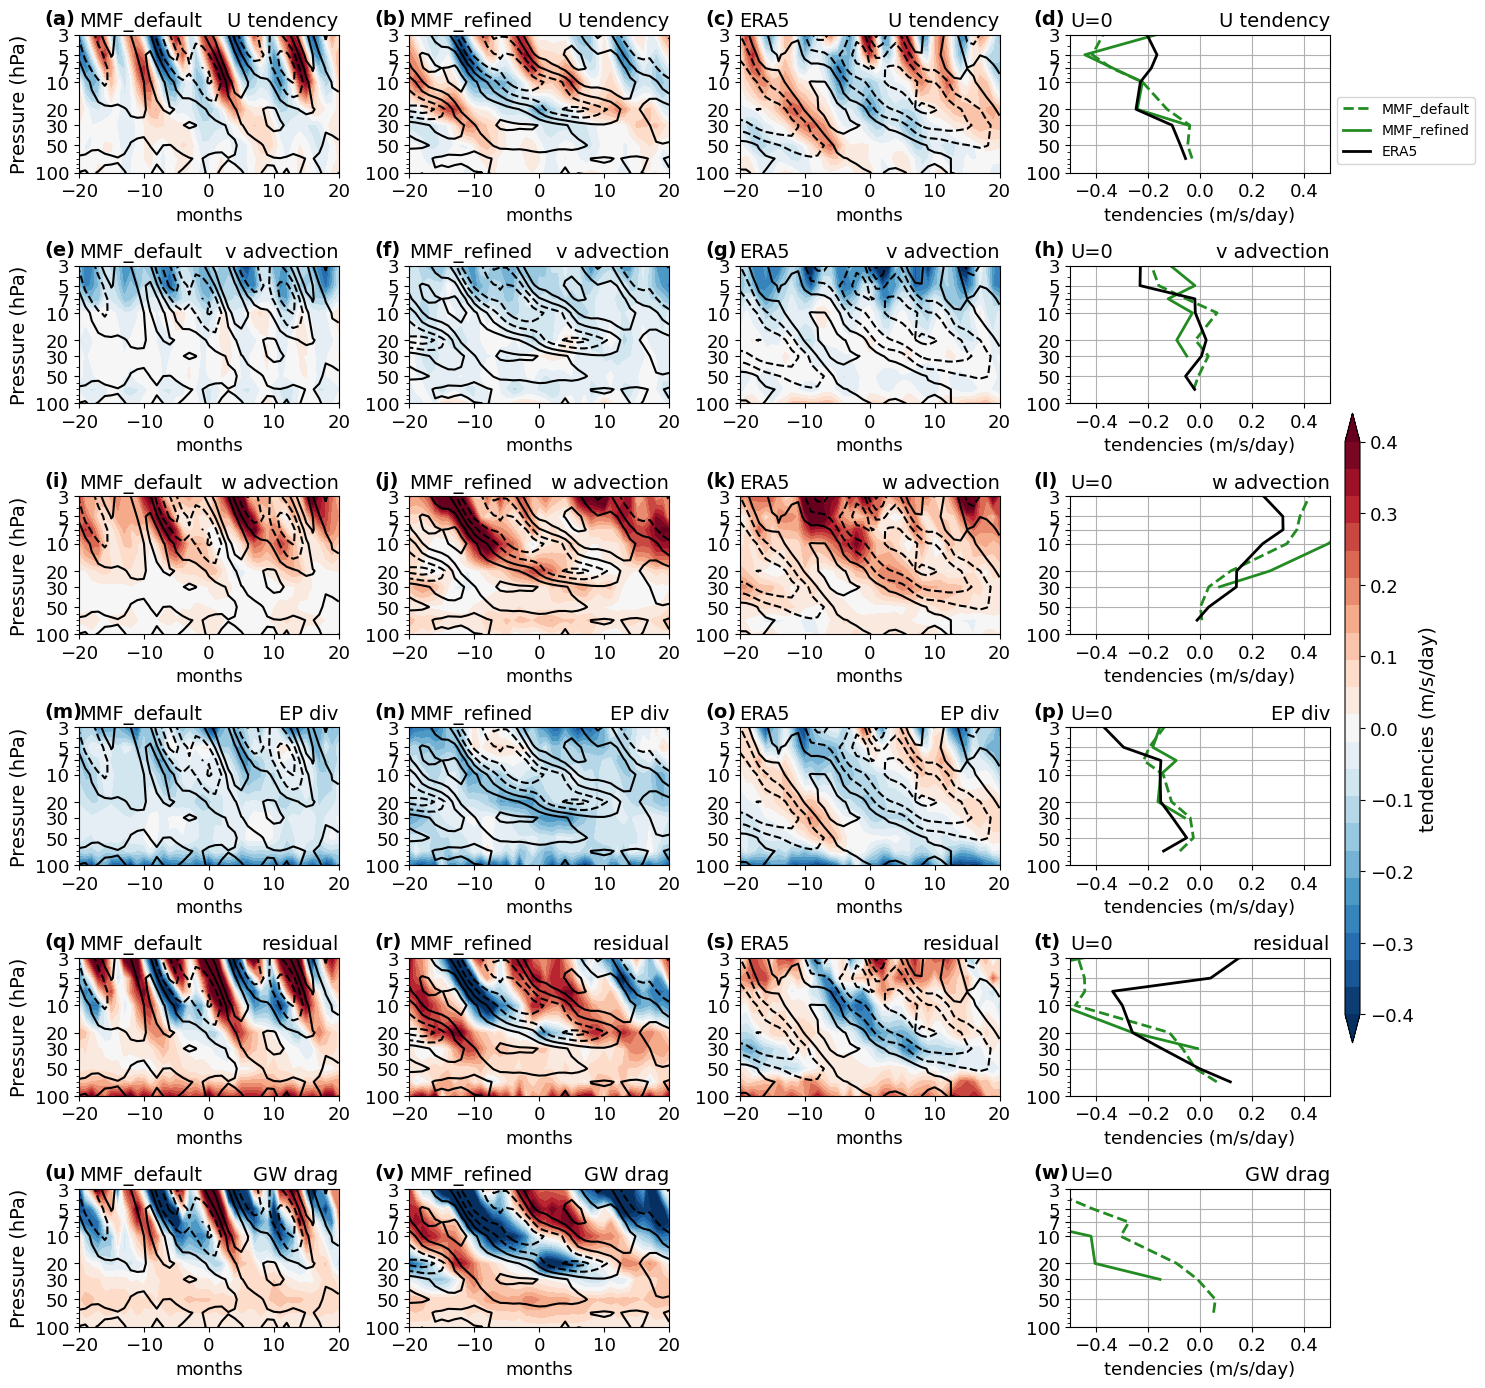

In [77]:
plt.figure(figsize=[15,14])
j = 1
for ii in range(6):
    descending_vars = []
    ifig = 0
    for c,name in enumerate(['MMF_default','MMF_refined','ERA5']): 
        
        var  = zonal_mean(data[name].sel(lev= 20,method='nearest'), 'u', -5,5).values
        qbo_tt = tt_qbo_statistics(var, 3)
        ttime = qbo_tt['transition_times']
        x  = zonal_mean(data[name], 'u', -5,5)
        v1 = data[name]['u'].differentiate(coord='time',datetime_unit='s')
        v2 = data[name]['utendvtem']
        v3 = data[name]['utendwtem']
        v4 = data[name]['utendepfd']
        v5 = v1-(v2+v3+v4)

        if ii == 0:
            var = v1
        elif ii == 1:
            var = v2
        elif ii == 2:
            var = v3
        elif ii == 3:
            var = v4
        elif ii == 4:
            var = v5
        else:
            if c == 2:
                continue 
            else:
                var = (data[name]['UTGWSPEC']+data[name]['BUTGWSPEC']+data[name]['UTGWORO'])
        
        x = xr.Dataset()
        x['x'] = var
        x  = zonal_mean(x, 'x', -5,5)
        composite = calculate_composite(x,ttime[j])*86400

        plt.subplot(6,4,1+c+ii*4)
        cx=plt.contourf(np.arange(-20,21),x.lev,composite.T,
                    levels=np.linspace(-0.4,0.4,22),cmap='RdBu_r',extend='both')
        x  = zonal_mean(data[name], 'u', -5,5)
        plt.contour(np.arange(-20,21),x.lev,calculate_composite(x,ttime[j]).T
                    ,colors='k',levels=np.arange(-30,35,10))        
        plt.yscale('log')

        if c == 0:
            plt.ylabel('Pressure (hPa)',fontsize=14)
        plt.ylim([100,3])
        titles = ['U tendency','v advection','w advection', 'EP div', 'residual','GW drag']
        plt.title(f'{name}',loc='left',fontsize=14)
        plt.title(f'{titles[ii]}',loc='right',fontsize=14)
        plt.xlabel('months',fontsize=13)
        plt.yticks([100,50,30,20,10,7,5,3],[100,50,30,20,10,7,5,3],fontsize=13)
        plt.xticks(fontsize=13)
        add_order(plt.gca(),c+ii*4,-25.3,2.3)
            
        x  = zonal_mean(data[name], 'u', -5,5)
        descending = transition_point(calculate_composite(x,ttime[j]),x.lev)
        if (name == 'E3SM_refined') and (j == 1):
            descending[28] = 20
            descending[27] = np.nan
        if (name == 'E3SM_default') and (j == 0):
            descending[33:] = descending[33:]+3
        if (name == 'MMF_refined') and (j == 1):
            descending[29] = 5
        if (name == 'MMF_default') and (j == 0):
            descending[27] = np.nan
        descending[np.where(x.lev>90)] = np.nan
        descending_var = np.ones(composite.shape[1])*np.nan
        for ilev in range(composite.shape[1]):
            if np.isfinite(descending[ilev]):
                itime = int(np.round(descending[ilev]))
                descending_var[ilev] = composite[itime,ilev]
        descending_vars.append(descending_var)
        
    plt.subplot(6,4,4+ii*4)
    for c in range(len(descending_vars)):
        plt.plot(descending_vars[c],x.lev,
                color=['forestgreen','forestgreen','k'][c],linewidth=2,
                label=['MMF_default','MMF_refined','ERA5'][c],
                linestyle=['--','-','-'][c])
    plt.yscale('log')
    # if (ii == 0) and (j==0):
    #     plt.legend()
    # if (ii == 2) and (j==1):
    #     plt.legend()
    if ii==0:
        plt.legend(bbox_to_anchor=(1, 0.6))
    plt.xlabel('tendencies (m/s/day)',fontsize=13)
    plt.yticks([100,50,30,20,10,7,5,3],[100,50,30,20,10,7,5,3],fontsize=13)
    plt.xticks(fontsize=13)
    plt.ylim([100,3])
    plt.xlim([-0.5,0.5])
    plt.grid(True)
    plt.title(f'U=0',loc='left',fontsize=14)
    plt.title(f'{titles[ii]}',loc='right',fontsize=14)
    if ii == 5:
        add_order(plt.gca(),2+ii*4,-0.64,2.3)
    else:
        add_order(plt.gca(),2+ii*4+1,-0.64,2.3)
    
plt.tight_layout()
plt.subplots_adjust(right=0.89)
cax1 = plt.axes([0.9, 0.25, 0.01, 0.45])
cb1 = plt.colorbar(cx,cax=cax1)
cb1.set_ticks(np.arange(-0.4,0.5,0.1))
cb1.set_label('tendencies (m/s/day)',fontsize=14)
cb1.ax.tick_params(labelsize=13)
plt.savefig(['figures/mmf_wave_drag_w.pdf','figures/mmf_wave_drag_e.pdf'][j])


## figure 7 & 9

8 8
10 9
12 13


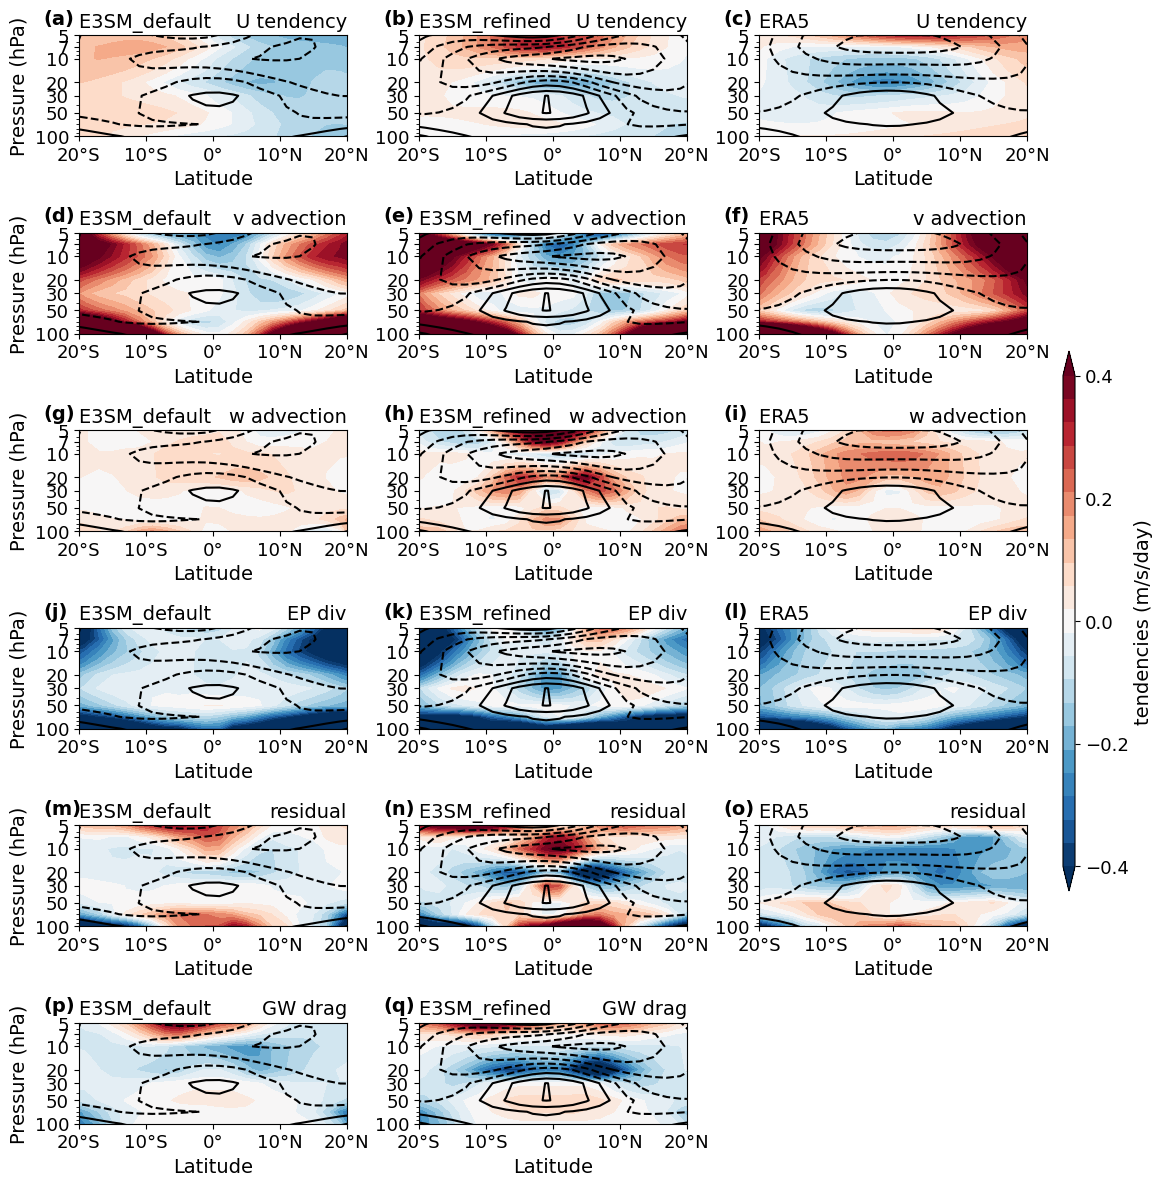

In [78]:
plt.figure(figsize=[12,12])
j = 1
for c,name in enumerate(['E3SM_default','E3SM_refined','ERA5']):
    var  = zonal_mean(data[name].sel(lev= 20,method='nearest'), 'u', -5,5).values
    qbo_tt = tt_qbo_statistics(var, 3)
    ttime = qbo_tt['transition_times']
    print (len(ttime[0]),len(ttime[1]))
    for i in range(6):
        v1 = data[name]['u'].differentiate(coord='time')
        v2 = data[name]['utendvtem']
        v3 = data[name]['utendwtem']
        v4 = data[name]['utendepfd']
        v5 = v1-(v2+v3+v4)

        if i == 0:
            var = v1
        elif i == 1:
            var = v2
        elif i == 2:
            var = v3
        elif i == 3:
            var = v4
        elif i == 4:
            var = v5
        else:
            if c == 2:
                continue 
            else:
                var = data[name]['UTGWSPEC']+data[name]['BUTGWSPEC']+data[name]['UTGWORO']
        plt.subplot(6,3,1+c+i*3)
        x = var[ttime[j]].mean(dim='time')
                 
        cx=plt.contourf(x.lat,x.lev,x.values*86400,cmap = 'RdBu_r',levels=np.linspace(-0.4,0.4,22),extend='both')      
        x = data[name]['u'][ttime[j]].mean(dim='time')
        plt.contour(x.lat,x.lev,x.values,levels=np.linspace(-35,35,10),colors='k')      
        titles = ['U tendency','v advection','w advection', 'EP div', 'residual','GW drag']

        plt.title(f'{name} ',loc='left',fontsize=14)
        plt.title(f'{titles[i]}',loc='right',fontsize=14)
        plt.xlim([-20,20])
        plt.xticks(plt.gca().get_xticks(), [print_lat(x) for x in plt.gca().get_xticks()],fontsize=13)
        plt.yscale('log')
        if c == 0:
            plt.ylabel('Pressure (hPa)',fontsize=14)
        plt.ylim([1e2,5])
        plt.yticks([100,50,30,20,10,7,5],[100,50,30,20,10,7,5],fontsize=13)
        plt.xlabel('Latitude',fontsize=14)
        add_order(plt.gca(),c+i*3,-25.3,3.6)
        
plt.tight_layout()
plt.subplots_adjust(right=0.86)
cax1 = plt.axes([0.89, 0.25, 0.01, 0.45])
cb1 = plt.colorbar(cx,cax=cax1)
cb1.set_ticks(np.arange(-0.4,0.5,0.2))
cb1.set_label('tendencies (m/s/day)',fontsize=14)
cb1.ax.tick_params(labelsize=13)
plt.savefig(['figures/wave_drag_lat_w.pdf','figures/wave_drag_lat_e.pdf'][j])

22 22
15 14
12 13


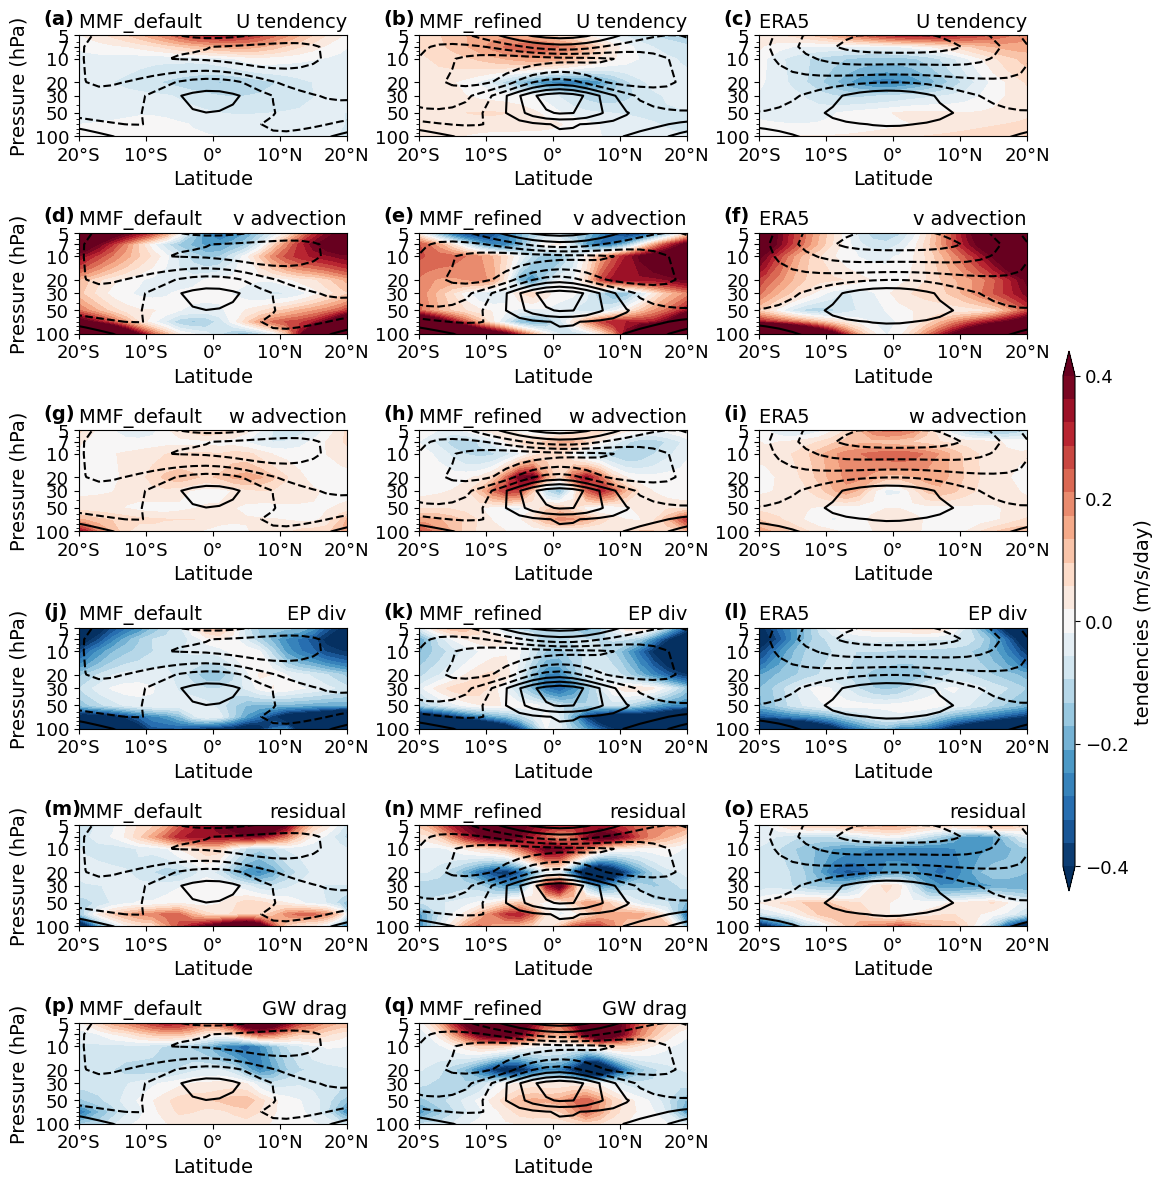

In [79]:
plt.figure(figsize=[12,12])
j = 1
for c,name in enumerate(['MMF_default','MMF_refined','ERA5']):
    var  = zonal_mean(data[name].sel(lev= 20,method='nearest'), 'u', -5,5).values
    qbo_tt = tt_qbo_statistics(var, 3)
    ttime = qbo_tt['transition_times']
    print (len(ttime[0]),len(ttime[1]))
    for i in range(6):
        v1 = data[name]['u'].differentiate(coord='time')
        v2 = data[name]['utendvtem']
        v3 = data[name]['utendwtem']
        v4 = data[name]['utendepfd']
        v5 = v1-(v2+v3+v4)

        if i == 0:
            var = v1
        elif i == 1:
            var = v2
        elif i == 2:
            var = v3
        elif i == 3:
            var = v4
        elif i == 4:
            var = v5
        else:
            if c == 2:
                continue 
            else:
                var = data[name]['UTGWSPEC']+data[name]['BUTGWSPEC']+data[name]['UTGWORO']
        plt.subplot(6,3,1+c+i*3)
        x = var[ttime[j]].mean(dim='time')
                 
        cx=plt.contourf(x.lat,x.lev,x.values*86400,cmap = 'RdBu_r',levels=np.linspace(-0.4,0.4,22),extend='both')      
        x = data[name]['u'][ttime[j]].mean(dim='time')
        plt.contour(x.lat,x.lev,x.values,levels=np.linspace(-35,35,10),colors='k')      
        titles = ['U tendency','v advection','w advection', 'EP div', 'residual','GW drag']

        plt.title(f'{name} ',loc='left',fontsize=14)
        plt.title(f'{titles[i]}',loc='right',fontsize=14)
        plt.xlim([-20,20])
        plt.xticks(plt.gca().get_xticks(), [print_lat(x) for x in plt.gca().get_xticks()],fontsize=13)
        plt.yscale('log')
        if c == 0:
            plt.ylabel('Pressure (hPa)',fontsize=14)
        plt.ylim([1e2,5])
        plt.yticks([100,50,30,20,10,7,5],[100,50,30,20,10,7,5],fontsize=13)
        plt.xlabel('Latitude',fontsize=14)
        add_order(plt.gca(),c+i*3,-25.3,3.6)
        
plt.tight_layout()
plt.subplots_adjust(right=0.86)
cax1 = plt.axes([0.89, 0.25, 0.01, 0.45])
cb1 = plt.colorbar(cx,cax=cax1)
cb1.set_ticks(np.arange(-0.4,0.5,0.2))
cb1.set_label('tendencies (m/s/day)',fontsize=14)
cb1.ax.tick_params(labelsize=13)
plt.savefig(['figures/mmf_wave_drag_lat_w.pdf','figures/mmf_wave_drag_lat_e.pdf'][j])

## figure 11

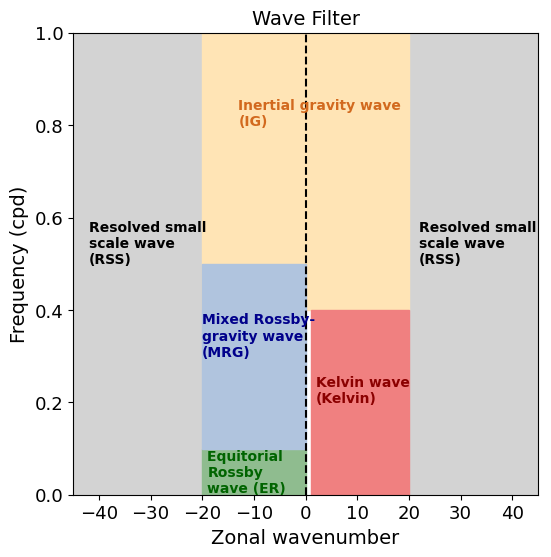

In [71]:
from matplotlib.patches import Rectangle
plt.figure(figsize=[6,6])
plt.axvline(0, linestyle='dashed', color='k')
plt.xlim([-45,45])
plt.ylim([0,1])    
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
#plt.title(f"{title} background")
plt.xlabel('Zonal wavenumber',fontsize=14)
plt.ylabel('Frequency (cpd)',fontsize=14)
rects = [
    Rectangle((-45, 0), 25,1, color ='lightgrey'),
    Rectangle((20, 0), 25,1, color ='lightgrey'),
    Rectangle((-20, 0.4), 40,1, color ='moccasin'),
    Rectangle((-20, 0), 20, 0.1, color ='darkseagreen'), 
    Rectangle((1, 0), 19,0.4, color ='lightcoral'),
    Rectangle((-20, 0.1), 20,0.4, color ='lightsteelblue'),
        ]
for r in rects:
    plt.gca().add_patch(r) 
plt.text(-42,0.5,'Resolved small \nscale wave\n(RSS)',weight='bold')
plt.text(22,0.5,'Resolved small \nscale wave\n(RSS)',weight='bold')
plt.text(-13,0.8,'Inertial gravity wave\n(IG)',weight='bold',color='chocolate')
plt.text(-20,0.3,'Mixed Rossby-\ngravity wave\n(MRG)',weight='bold',color='darkblue')
plt.text(-19,0.005,'Equitorial \nRossby\nwave (ER)',weight='bold',color='darkgreen')
plt.text(2,0.2,'Kelvin wave\n(Kelvin)',weight='bold',color='darkred')

plt.title('Wave Filter',fontsize=14)
plt.savefig('figures/wave_filter.pdf')

## figure 12 & 13

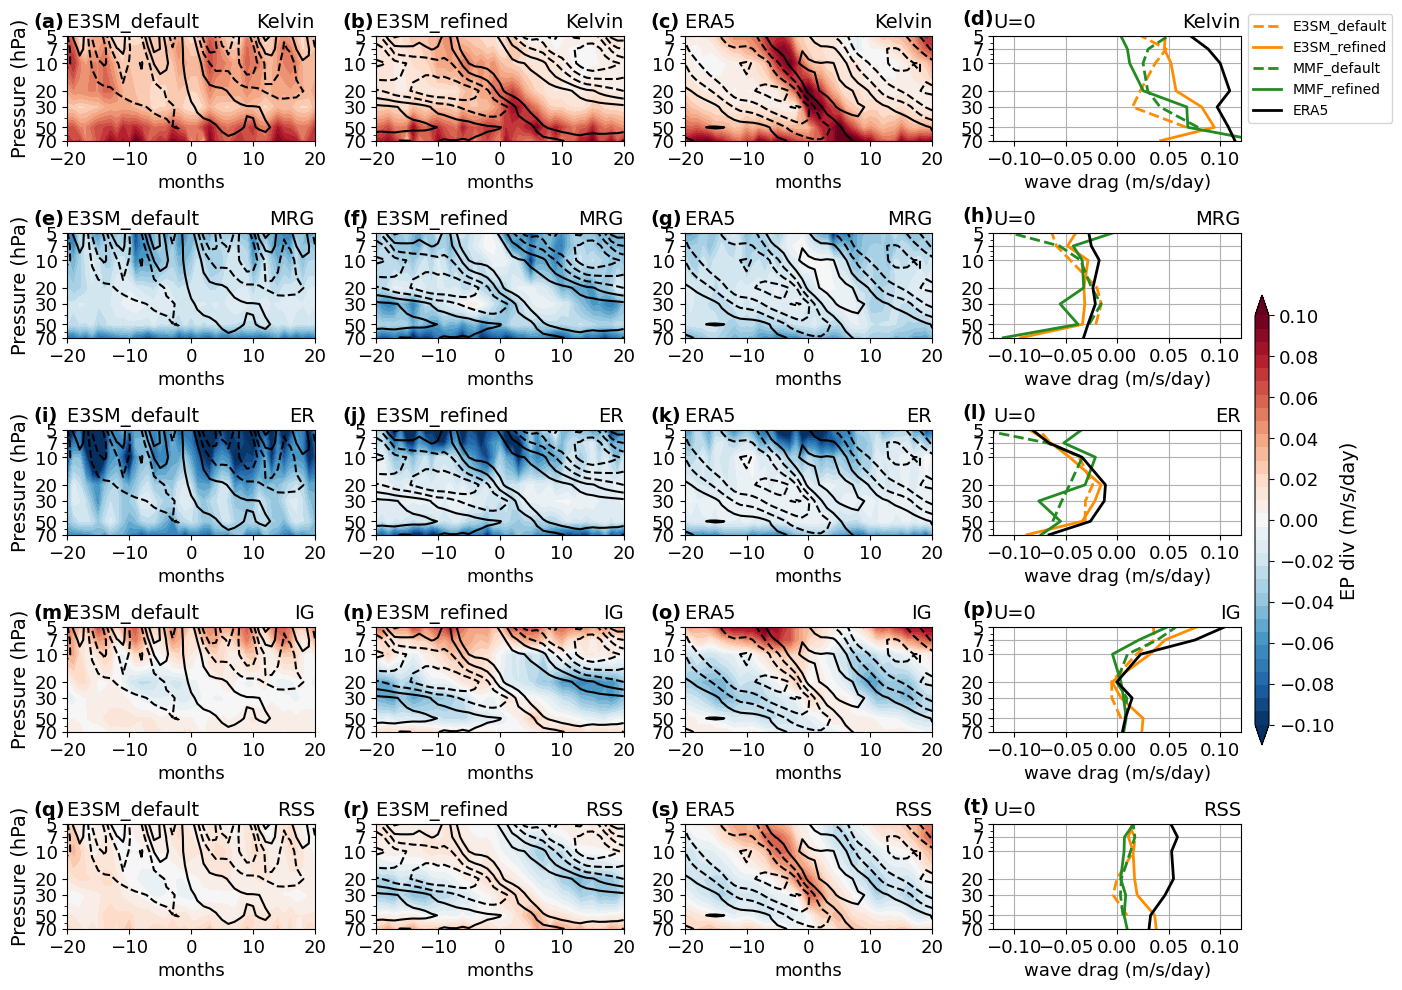

In [70]:
plt.figure(figsize=[14,10])
j = 0
for ii,wave in enumerate(['kelvin','mrg','rossby','ig','ssg']):
    descending_vars = []
    ifig = 0
    for c,name in enumerate(['E3SM_default','E3SM_refined','MMF_default','MMF_refined','ERA5']): 
        var  = zonal_mean(data[name].sel(lev= 20,method='nearest'), 'u', -5,5).values
        qbo_tt = tt_qbo_statistics(var, 2)
        ttime = qbo_tt['transition_times']
        x  = zonal_mean(filtered[name], wave, -5,5)
        composite = calculate_composite(x,ttime[j])*86400
        if c in [0,1,4]:
            ifig += 1 
            plt.subplot(5,4,ifig+ii*4)
            cx=plt.contourf(np.arange(-20,21),x.lev,composite.T,
                    levels=np.linspace(-0.1,0.1,32),cmap='RdBu_r',extend='both')
            x  = zonal_mean(data[name], 'u', -5,5)
            plt.contour(np.arange(-20,21),x.lev,calculate_composite(x,ttime[j]).T
                        ,colors='k',levels=np.arange(-30,35,10))

            plt.yscale('log')
            if c == 0:
                plt.ylabel('Pressure (hPa)',fontsize=14)
            plt.ylim([70,5])
            titles = ['Kelvin','MRG','ER','IG','RSS']
            plt.title(f'{name} ',loc='left',fontsize=14)
            plt.title(f'{titles[ii]}',loc='right',fontsize=14)
            plt.xlabel('months',fontsize=13)
            plt.yticks([70,50,30,20,10,7,5],[70,50,30,20,10,7,5],fontsize=13)
            plt.xticks(fontsize=13)
            add_order(plt.gca(),ifig+ii*4-1,-25.5,4.1)
        
        x  = zonal_mean(data[name], 'u', -5,5)
        descending = transition_point(calculate_composite(x,ttime[j]),x.lev)
        if (name == 'E3SM_refined') and (j == 1):
            descending[28] = 20
            descending[27] = np.nan
        if (name == 'E3SM_default') and (j == 0):
            descending[33:] = descending[33:]+3
        if (name == 'MMF_refined') and (j == 1):
            descending[29] = 5
        if (name == 'MMF_default') and (j == 0):
            descending[27] = np.nan
        descending[np.where(x.lev>90)] = np.nan
        descending_var = np.ones(composite.shape[1])*np.nan
        for ilev in range(composite.shape[1]):
            if np.isfinite(descending[ilev]):
                itime = int(np.round(descending[ilev]))
                descending_var[ilev] = composite[itime,ilev]
        descending_vars.append(descending_var)

    plt.subplot(5,4,4+ii*4)
    for c in range(len(descending_vars)):
        plt.plot(descending_vars[c],x.lev,
                color=['darkorange','darkorange','forestgreen','forestgreen','k'][c],linewidth=2,
                label=['E3SM_default','E3SM_refined','MMF_default','MMF_refined','ERA5',][c],
                linestyle=['--','-','--','-','-'][c])
    plt.yscale('log')
    if ii==0:
        if j == 0:
            plt.legend(bbox_to_anchor=(1, 0.1))
        if j == 1:
            plt.legend(bbox_to_anchor=(1, 0.6))
    plt.xlabel('wave drag (m/s/day)',fontsize=13)
    plt.ylim([70,5])
    plt.yticks([70,50,30,20,10,7,5],[70,50,30,20,10,7,5],fontsize=13)
    plt.xticks(fontsize=13)
    plt.xlim([-0.12,0.12])
    plt.grid(True)
    plt.title(f'U=0',loc='left',fontsize=14)
    plt.title(f'{titles[ii]}',loc='right',fontsize=14)
    add_order(plt.gca(),3+ii*4,-0.15,3.8)
    
import matplotlib.cm as cm
import matplotlib.colorbar as colorbar
import matplotlib.colors as colors
plt.tight_layout()
plt.tight_layout()
plt.subplots_adjust(right=0.89)
cax1 = plt.axes([0.9, 0.25, 0.01, 0.45])
cb1 = plt.colorbar(cx,cax=cax1)
cb1.set_label('EP div (m/s/day)',fontsize=14)
cb1.set_ticks(np.arange(-0.1,0.11,0.02))
cb1.ax.tick_params(labelsize=13)
plt.savefig(['figures/ev_div_filter_w.pdf','figures/ev_div_filter_e.pdf'][j])


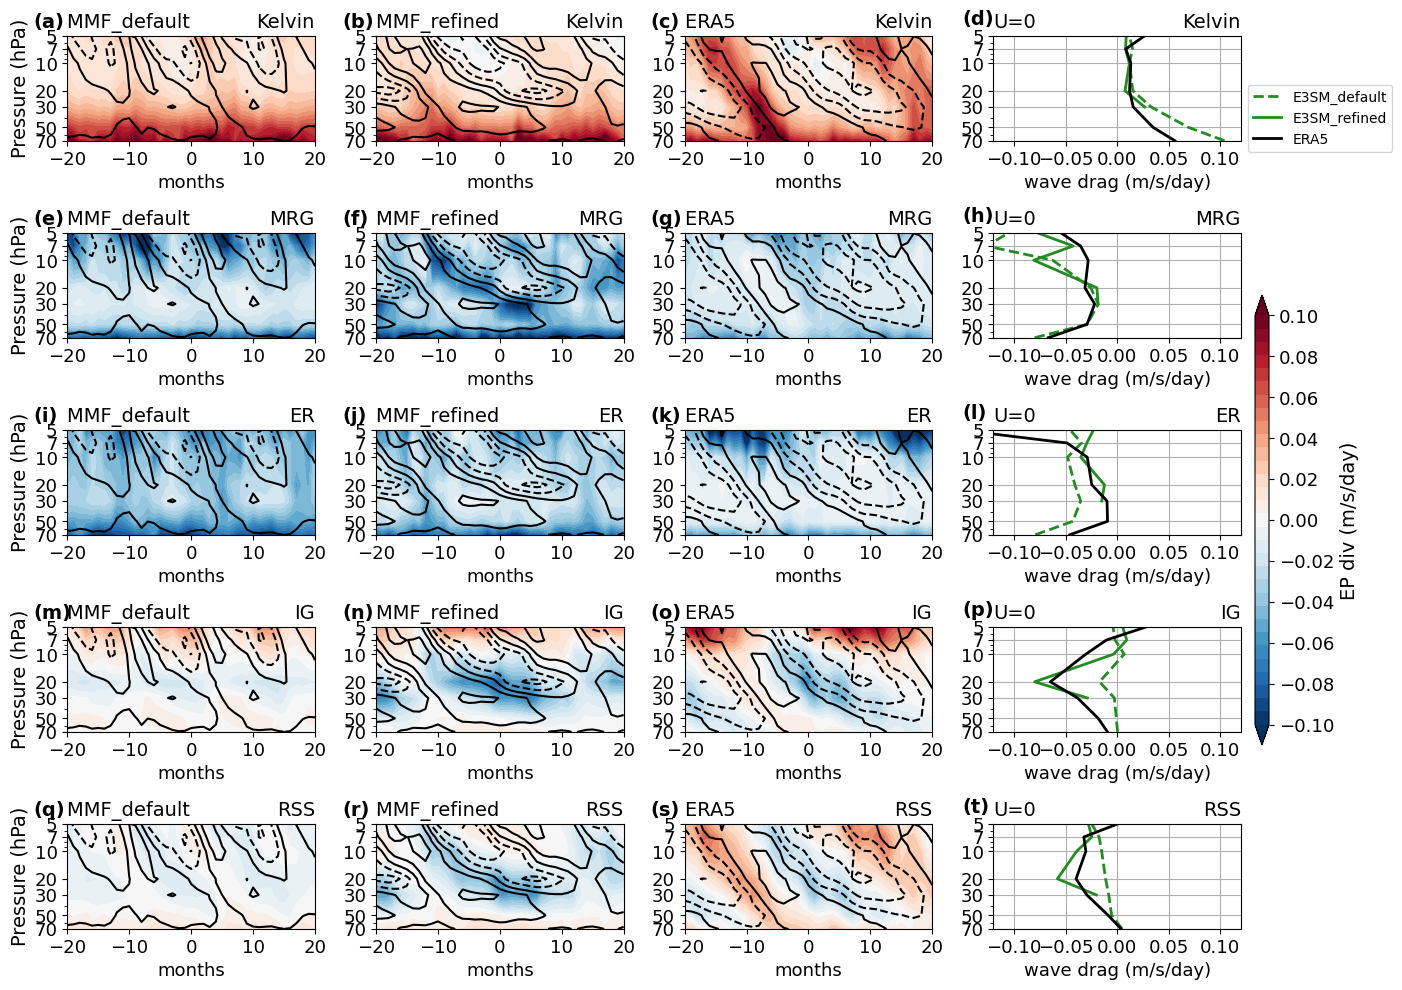

In [72]:
plt.figure(figsize=[14,10])
j = 1
for ii,wave in enumerate(['kelvin','mrg','rossby','ig','ssg']):
    descending_vars = []
    for c,name in enumerate(['MMF_default','MMF_refined','ERA5']): 
        plt.subplot(5,4,1+c+ii*4)
        var  = zonal_mean(data[name].sel(lev= 20,method='nearest'), 'u', -5,5).values
        qbo_tt = tt_qbo_statistics(var, 2)
        ttime = qbo_tt['transition_times']
        x  = zonal_mean(filtered[name], wave, -5,5)
        composite = calculate_composite(x,ttime[j])*86400
        cx=plt.contourf(np.arange(-20,21),x.lev,composite.T,
                    levels=np.linspace(-0.1,0.1,32),cmap='RdBu_r',extend='both')
        x  = zonal_mean(data[name], 'u', -5,5)
        plt.contour(np.arange(-20,21),x.lev,calculate_composite(x,ttime[j]).T
                    ,colors='k',levels=np.arange(-30,35,10))

        plt.yscale('log')
        if c == 0:
            plt.ylabel('Pressure (hPa)',fontsize=14)
        plt.ylim([70,5])
        titles = ['Kelvin','MRG','ER','IG','RSS']
        plt.title(f'{name} ',loc='left',fontsize=14)
        plt.title(f'{titles[ii]}',loc='right',fontsize=14)
        plt.xlabel('months',fontsize=13)
        plt.yticks([70,50,30,20,10,7,5],[70,50,30,20,10,7,5],fontsize=13)
        plt.xticks(fontsize=13)
        add_order(plt.gca(),c+ii*4,-25.5,4.1)
        
        x  = zonal_mean(data[name], 'u', -5,5)
        descending = transition_point(calculate_composite(x,ttime[j]),x.lev)
        if (name == 'E3SM_refined') and (j == 1):
            descending[28] = 20
            descending[27] = np.nan
        # if (name == 'E3SM_default') and (j == 0):
        #     descending[33:] = descending[33:]+3
        if (name == 'MMF_refined') and (j == 1):
            descending[29] = 5
        if (name == 'MMF_default') and (j == 0):
            descending[27] = np.nan
        descending[np.where(x.lev>90)] = np.nan
        descending_var = np.ones(composite.shape[1])*np.nan
        for ilev in range(composite.shape[1]):
            if np.isfinite(descending[ilev]):
                itime = int(np.round(descending[ilev]))
                descending_var[ilev] = composite[itime,ilev]
        descending_vars.append(descending_var)

    plt.subplot(5,4,4+ii*4)
    for c in range(len(descending_vars)):
        plt.plot(descending_vars[c],x.lev,
                color=['forestgreen','forestgreen','k','forestgreen','forestgreen'][c],linewidth=2,
                label=['E3SM_default','E3SM_refined','ERA5','MMF_default','MMF_refined'][c],
                linestyle=['--','-','-','--','-'][c])
    plt.yscale('log')
    if ii==0:
        if j == 0:
            plt.legend(bbox_to_anchor=(1, 0.1))
        if j == 1:
            plt.legend(bbox_to_anchor=(1, 0.6))
    plt.xlabel('wave drag (m/s/day)',fontsize=13)
    plt.ylim([70,5])
    plt.yticks([70,50,30,20,10,7,5],[70,50,30,20,10,7,5],fontsize=13)
    plt.xticks(fontsize=13)
    plt.xlim([-0.12,0.12])
    plt.grid(True)
    plt.title(f'U=0',loc='left',fontsize=14)
    plt.title(f'{titles[ii]}',loc='right',fontsize=14)
    add_order(plt.gca(),3+ii*4,-0.15,3.8)
    
import matplotlib.cm as cm
import matplotlib.colorbar as colorbar
import matplotlib.colors as colors
plt.tight_layout()
plt.tight_layout()
plt.subplots_adjust(right=0.89)
cax1 = plt.axes([0.9, 0.25, 0.01, 0.45])
cb1 = plt.colorbar(cx,cax=cax1)
cb1.set_label('EP div (m/s/day)',fontsize=14)
cb1.set_ticks(np.arange(-0.1,0.11,0.02))
cb1.ax.tick_params(labelsize=13)
plt.savefig(['figures/mmf_ev_div_filter_w.pdf','figures/mmf_ev_div_filter_e.pdf'][j])


## old figure 6 & 7

In [ ]:
from matplotlib.gridspec import GridSpec

labels = ['descending westerly', 'descending easterly']
fig = plt.figure(figsize=[11,4.5])
gs = GridSpec(1,9)
ax11 = fig.add_subplot(gs[0:3])
ax12 = fig.add_subplot(gs[3], sharey=ax11)
ax21 = fig.add_subplot(gs[5:8])
ax22 = fig.add_subplot(gs[8], sharey=ax21)

fig.subplots_adjust(wspace=0.23)  # adjust space between Axes
for i in range(2):
    ax1, ax2 = [[ax11,ax12],[ax21,ax22]][i]
    # plot the same data on both Axes
    for j,name in enumerate(['E3SM_refined','E3SM_default', 'MMF_refined', 'MMF_default', 'ERA5']):
        linewidth = 2 if name == 'ERA5' else 1.5
        ax1.plot(-speeds[name][i],data[name].lev,color = data_colors[name], linewidth=linewidth,
            linestyle = linestyles[name],label=name)
        ax2.plot(-speeds[name][i],data[name].lev,color = data_colors[name], linewidth=linewidth,
            linestyle = linestyles[name],label=name)

    ax1.set_yscale('log')
    ax1.set_ylim([70,3])
    ax1.grid(True)
    ax1.set_yticks([70,50,30,20,10,7,5,3],[70,50,30,20,10,7,5,3])
    ax1.set_xlabel('descent speed (km/month)')
    case = ['west','east'][i]
    ax1.set_title(f'{labels[i]}',loc='left')
    ax2.set_title(f'descent speed',loc='right')
    if i == 0:
        ax1.legend(bbox_to_anchor=(-0.05, -0.27, 1.5, .102), loc='lower left',
           ncols=3, mode="expand", borderaxespad=0.)


#add_order(plt.gca(),i,-0.5,2.7)
    ax1.set_ylabel('Pressure (hPa)')
    # zoom-in / limit the view to different portions of the data

    ax1.set_xlim([0, 4])  # most of the data
    ax1.set_xticks(range(5))
    if i == 0:
        ax2.set_xticks([7,8])
        ax2.set_xlim([7, 8])  # outliers only
    else:
        ax2.set_xticks([5,6])
        ax2.set_xlim([5, 6])  # outliers only
    # hide the spines between ax and ax2
    ax1.spines.right.set_visible(False)
    ax2.spines.left.set_visible(False)
    #ax1.yaxis.tick_left()
    ax2.yaxis.tick_right()
    ax2.tick_params(labelleft=False)  # don't put tick labels at the top
    ax1.grid(True)
    ax2.grid(True)
    d = .5  # proportion of vertical to horizontal extent of the slanted line
    kwargs = dict(marker=[(-d, -1), (d, 1)], markersize=12,
                  linestyle="none", color='k', mec='k', mew=1, clip_on=False)
    ax1.plot([1, 1], [0, 1], transform=ax1.transAxes, **kwargs)
    ax2.plot([0, 0], [1, 0], transform=ax2.transAxes, **kwargs)
    add_order(ax1,i,-0.5,2.7)

#plt.tight_layout()
plt.savefig('figures/descent_speed.pdf')


NameError: name 'speeds' is not defined

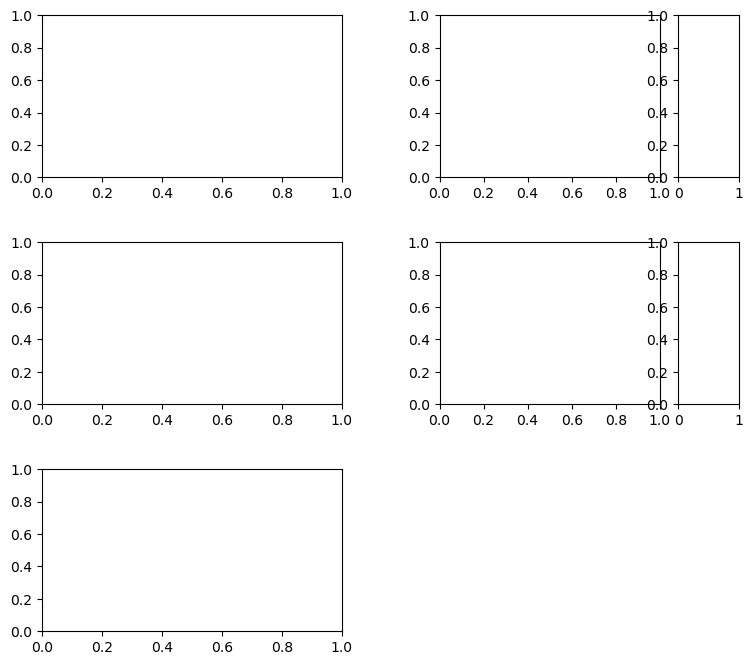

In [41]:
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=[9,8])
colors = ['indianred','royalblue']
labels = ['descending westerly', 'descending easterly']
gs = GridSpec(3,9)
fig.subplots_adjust(wspace=0.3,hspace=0.4)  # adjust space between Axes
ax11 = fig.add_subplot(gs[0,0:4])
ax12 = fig.add_subplot(gs[0,5:8])
ax13 = fig.add_subplot(gs[0,8], sharey=ax12)

ax21 = fig.add_subplot(gs[1,0:4])
ax22 = fig.add_subplot(gs[1,5:8])
ax23 = fig.add_subplot(gs[1,8], sharey=ax22)

ax31 = fig.add_subplot(gs[2,0:4])

for j,name in enumerate(['E3SM_refined','E3SM_default', 'MMF_refined', 'MMF_default', 'ERA5']):
    if j%2 == 0:
        ax = [ax11,ax21,ax31][j//2]
        for i in range(2):
            ax.plot(-speeds[name][i],data[name].lev,color=colors[i],label=labels[i],linewidth=2)

        ax.set_xlim([0,4])
        ax.set_yscale('log')
        ax.set_ylim([70,3])
        ax.set_label('descent speed (km/month)')
        case = ['west','east'][i]
        ax.set_title(f'{name}',loc='left')
        ax.set_title(f'descent speed',loc='right')
        ax.set_xticks(range(0,5))
        if j == 0:
            ax.legend()
        ax.grid(True)
        ax.set_yticks([70,50,30,20,10,7,5,3],[70,50,30,20,10,7,5,3])
        add_order(ax,j,-0.4,2.6)
        ax.set_ylabel('Pressure (hPa)')
        ax.set_xlabel('descent speed (km/month)')
    if j%2 == 1:
        ax1,ax2 = [(ax12,ax13),(ax22,ax23)][j//2]
        for i in range(2):
            ax1.plot(-speeds[name][i],data[name].lev,color=colors[i],label=labels[i],linewidth=2)
            ax2.plot(-speeds[name][i],data[name].lev,color=colors[i],label=labels[i],linewidth=2)
        # set axis 
        ax1.set_yscale('log')
        ax1.set_ylim([70,3])
        ax1.grid(True)
        ax1.set_yticks([70,50,30,20,10,7,5,3],[70,50,30,20,10,7,5,3])
        ax1.set_xlabel('descent speed (km/month)')
        case = ['west','east'][i]
        ax1.set_title(f'{name}',loc='left')
        ax2.set_title(f'descent speed',loc='right')
        ax1.set_ylabel('Pressure (hPa)')
        
        # set axis break 
        ax1.set_xlim([0, 3])  # most of the data
        ax1.set_xticks(range(4))

        ax2.set_xticks([6.5,7.5])
        ax2.set_xlim([6.5, 7.5])  # outliers only
        
        ax1.spines.right.set_visible(False)
        ax2.spines.left.set_visible(False)
        #ax1.yaxis.tick_left()
        ax2.yaxis.tick_right()
        ax2.tick_params(labelleft=False)  # don't put tick labels at the top
        ax1.grid(True)
        ax2.grid(True)
        d = .5  # proportion of vertical to horizontal extent of the slanted line
        kwargs = dict(marker=[(-d, -1), (d, 1)], markersize=12,
                      linestyle="none", color='k', mec='k', mew=1, clip_on=False)
        ax1.plot([1, 1], [0, 1], transform=ax1.transAxes, **kwargs)
        ax2.plot([0, 0], [1, 0], transform=ax2.transAxes, **kwargs)
        add_order(ax1,j,-0.5,2.6)
#plt.tight_layout()
#plt.savefig('figures/descent_speed.pdf')

